In [1]:
# !pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold,  StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    fbeta_score, make_scorer, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, balanced_accuracy_score,  confusion_matrix, classification_report
)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')
import joblib
import json

## A.Loading Data

In [3]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
data.shape

(41188, 21)

In [6]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

## B.Data Preparation

### 1.About data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### 2.Check for missing values and duplicate data

In [9]:
data.isnull().sum().sum()

np.int64(0)

In [10]:
#Check duplicate
data[data.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


In [11]:
#Remove duplicate
data = data.drop_duplicates()
data[data.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


### 3.Check for messy values

In [12]:
cat_col = data.select_dtypes(['object']).columns
num_col = data.select_dtypes(['int', 'float']).columns

In [13]:
for col in cat_col:
    print(data[col].value_counts())
    for i in range(50):
        print('*', end='')
    print('\n')

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
**************************************************

marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
**************************************************

education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
**************************************************

default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
**************************************************

housing
yes        21571
no

Tuy bộ dữ liệu không có giá trị khuyết thiếu nào nhưng thực ra có rất nhiều các giá trị ‘unknown’, ‘nonexistent’

### 4.Check for outliers

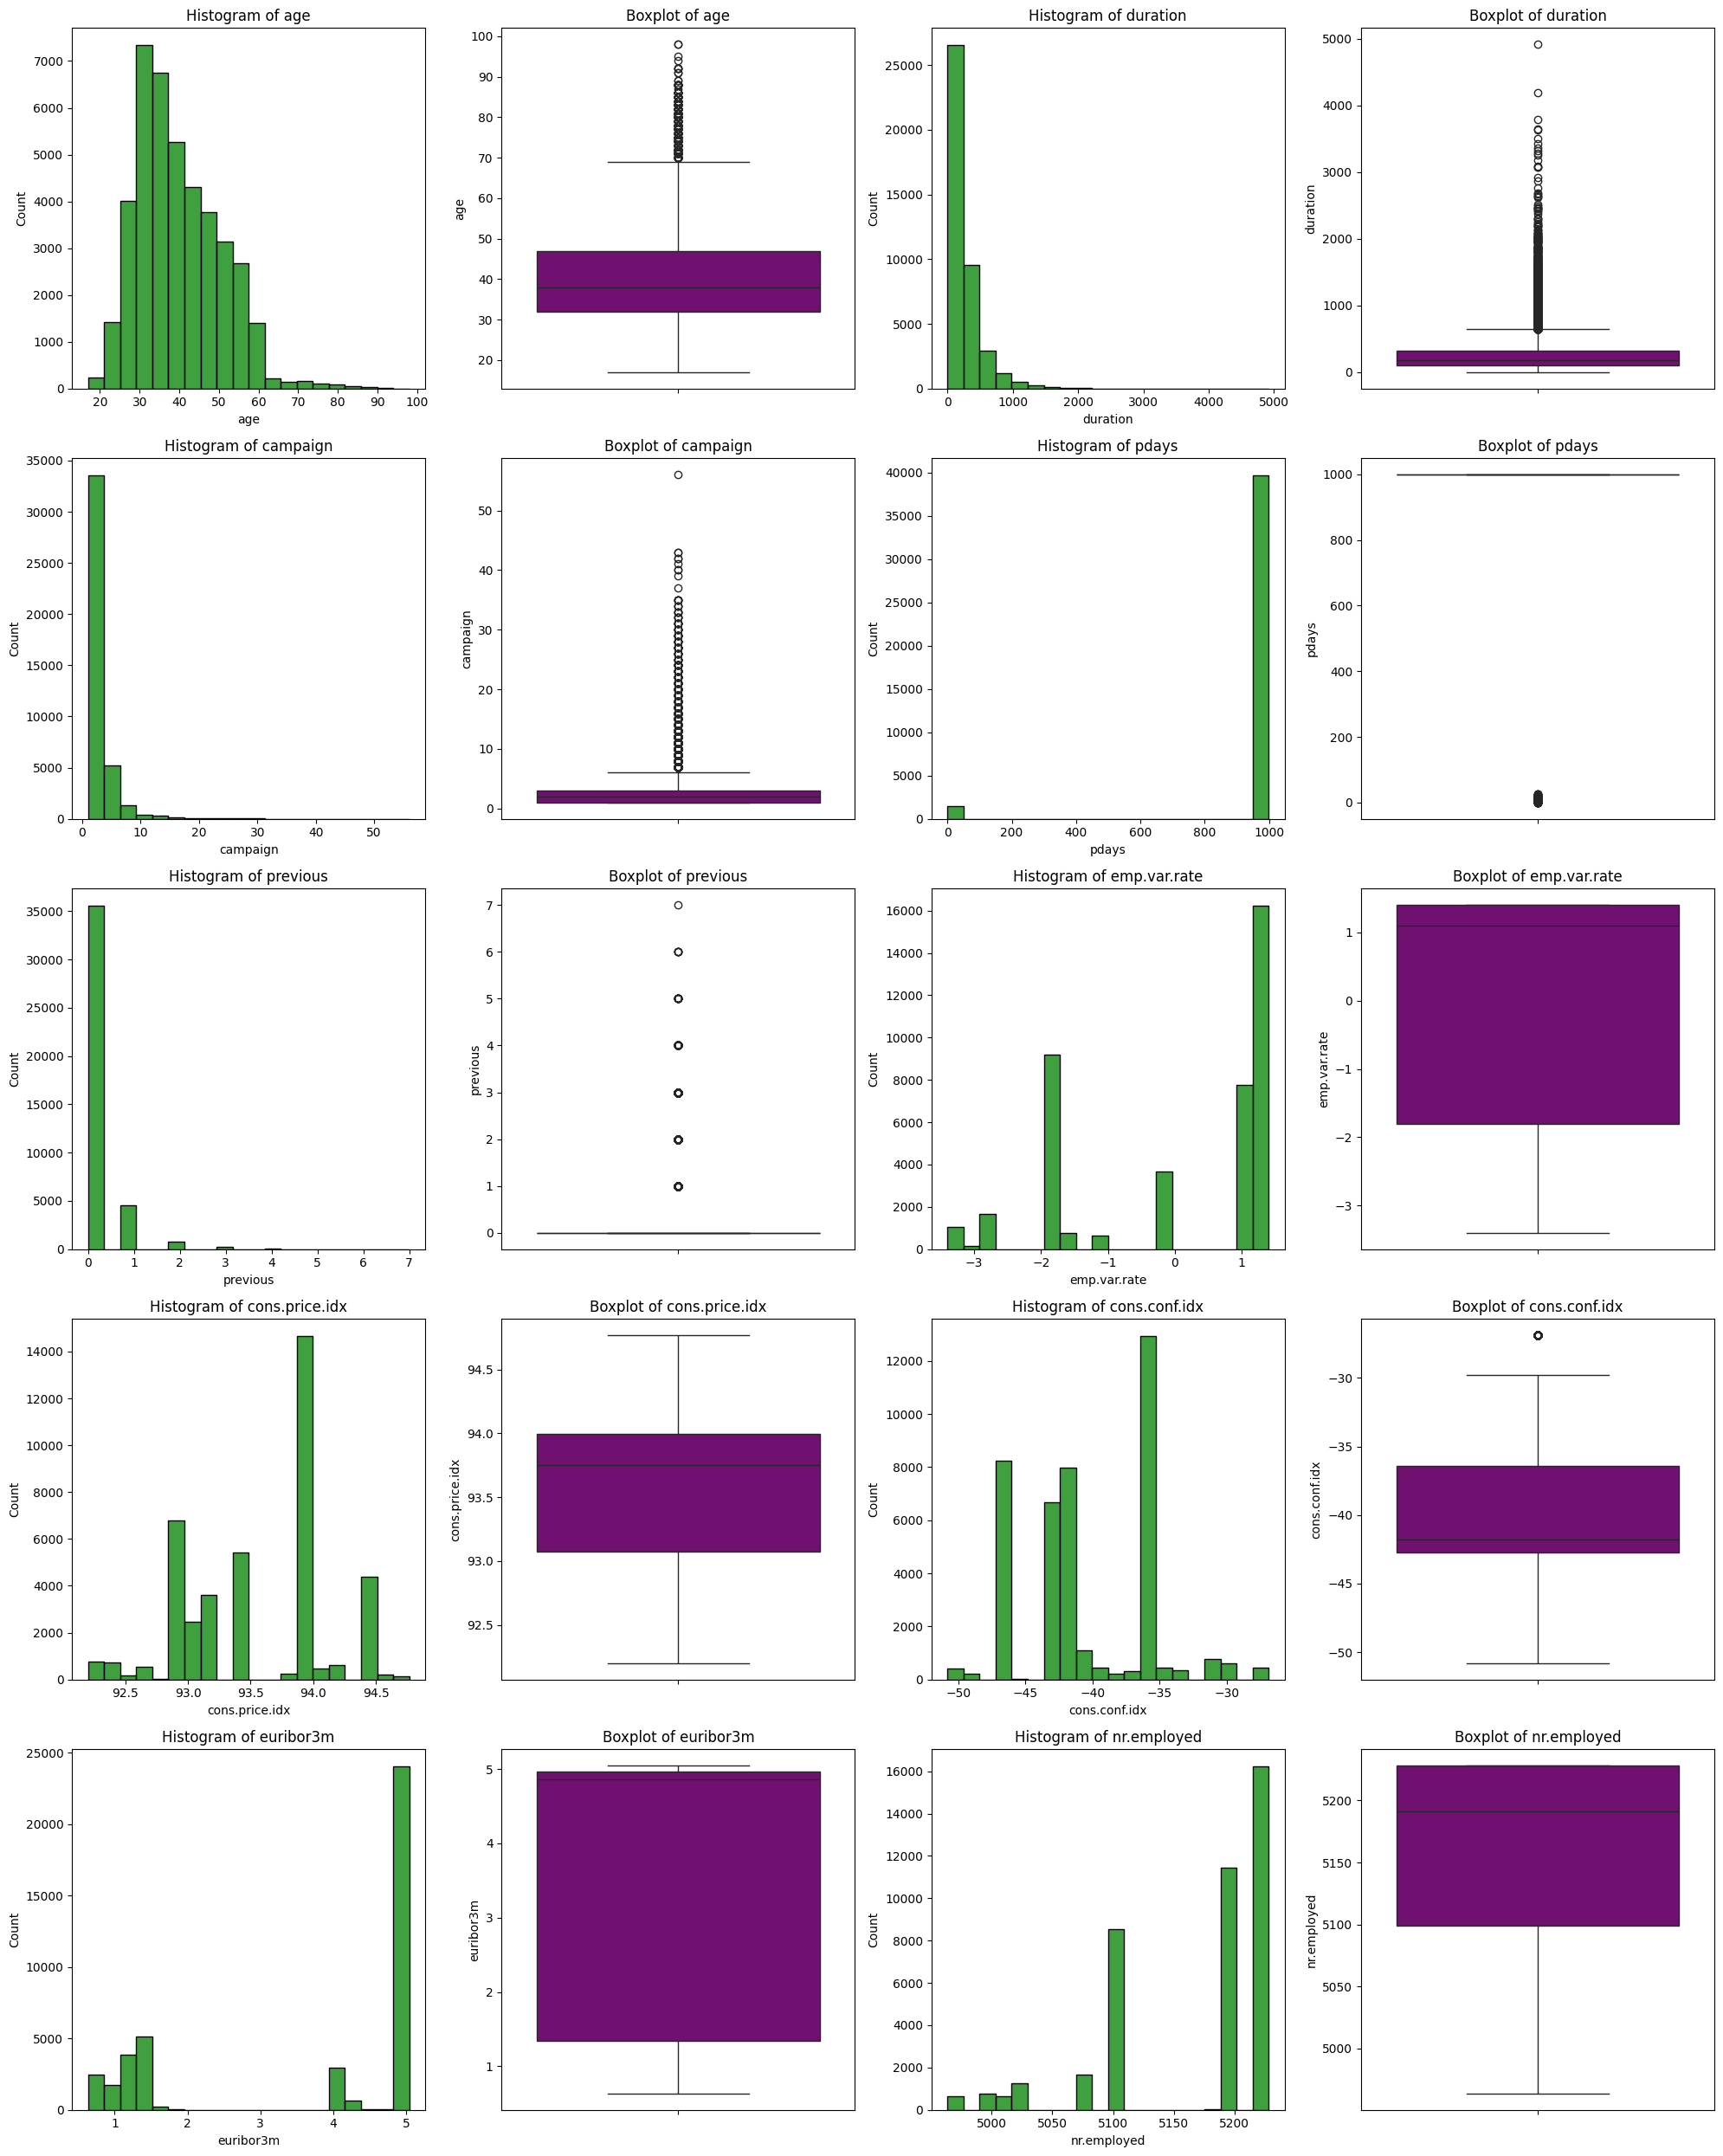

In [14]:
plt.figure(figsize=(4*5, 5*5))
for i, attr in enumerate(num_col, 1):
    plt.subplot(5, 4, 2*(i-1)+1)
    sns.histplot(data, x=attr, color='green', bins=20)
    plt.title(f'Histogram of {attr}')

    plt.subplot(5, 4, 2*(i-1)+2)
    sns.boxplot(data, y=attr, color='purple')
    plt.title(f'Boxplot of {attr}')

plt.tight_layout()
plt.show()

## C.Univariate Analysis

**The frequency of different categories within each feature**

In [15]:
data_vis = data.copy()

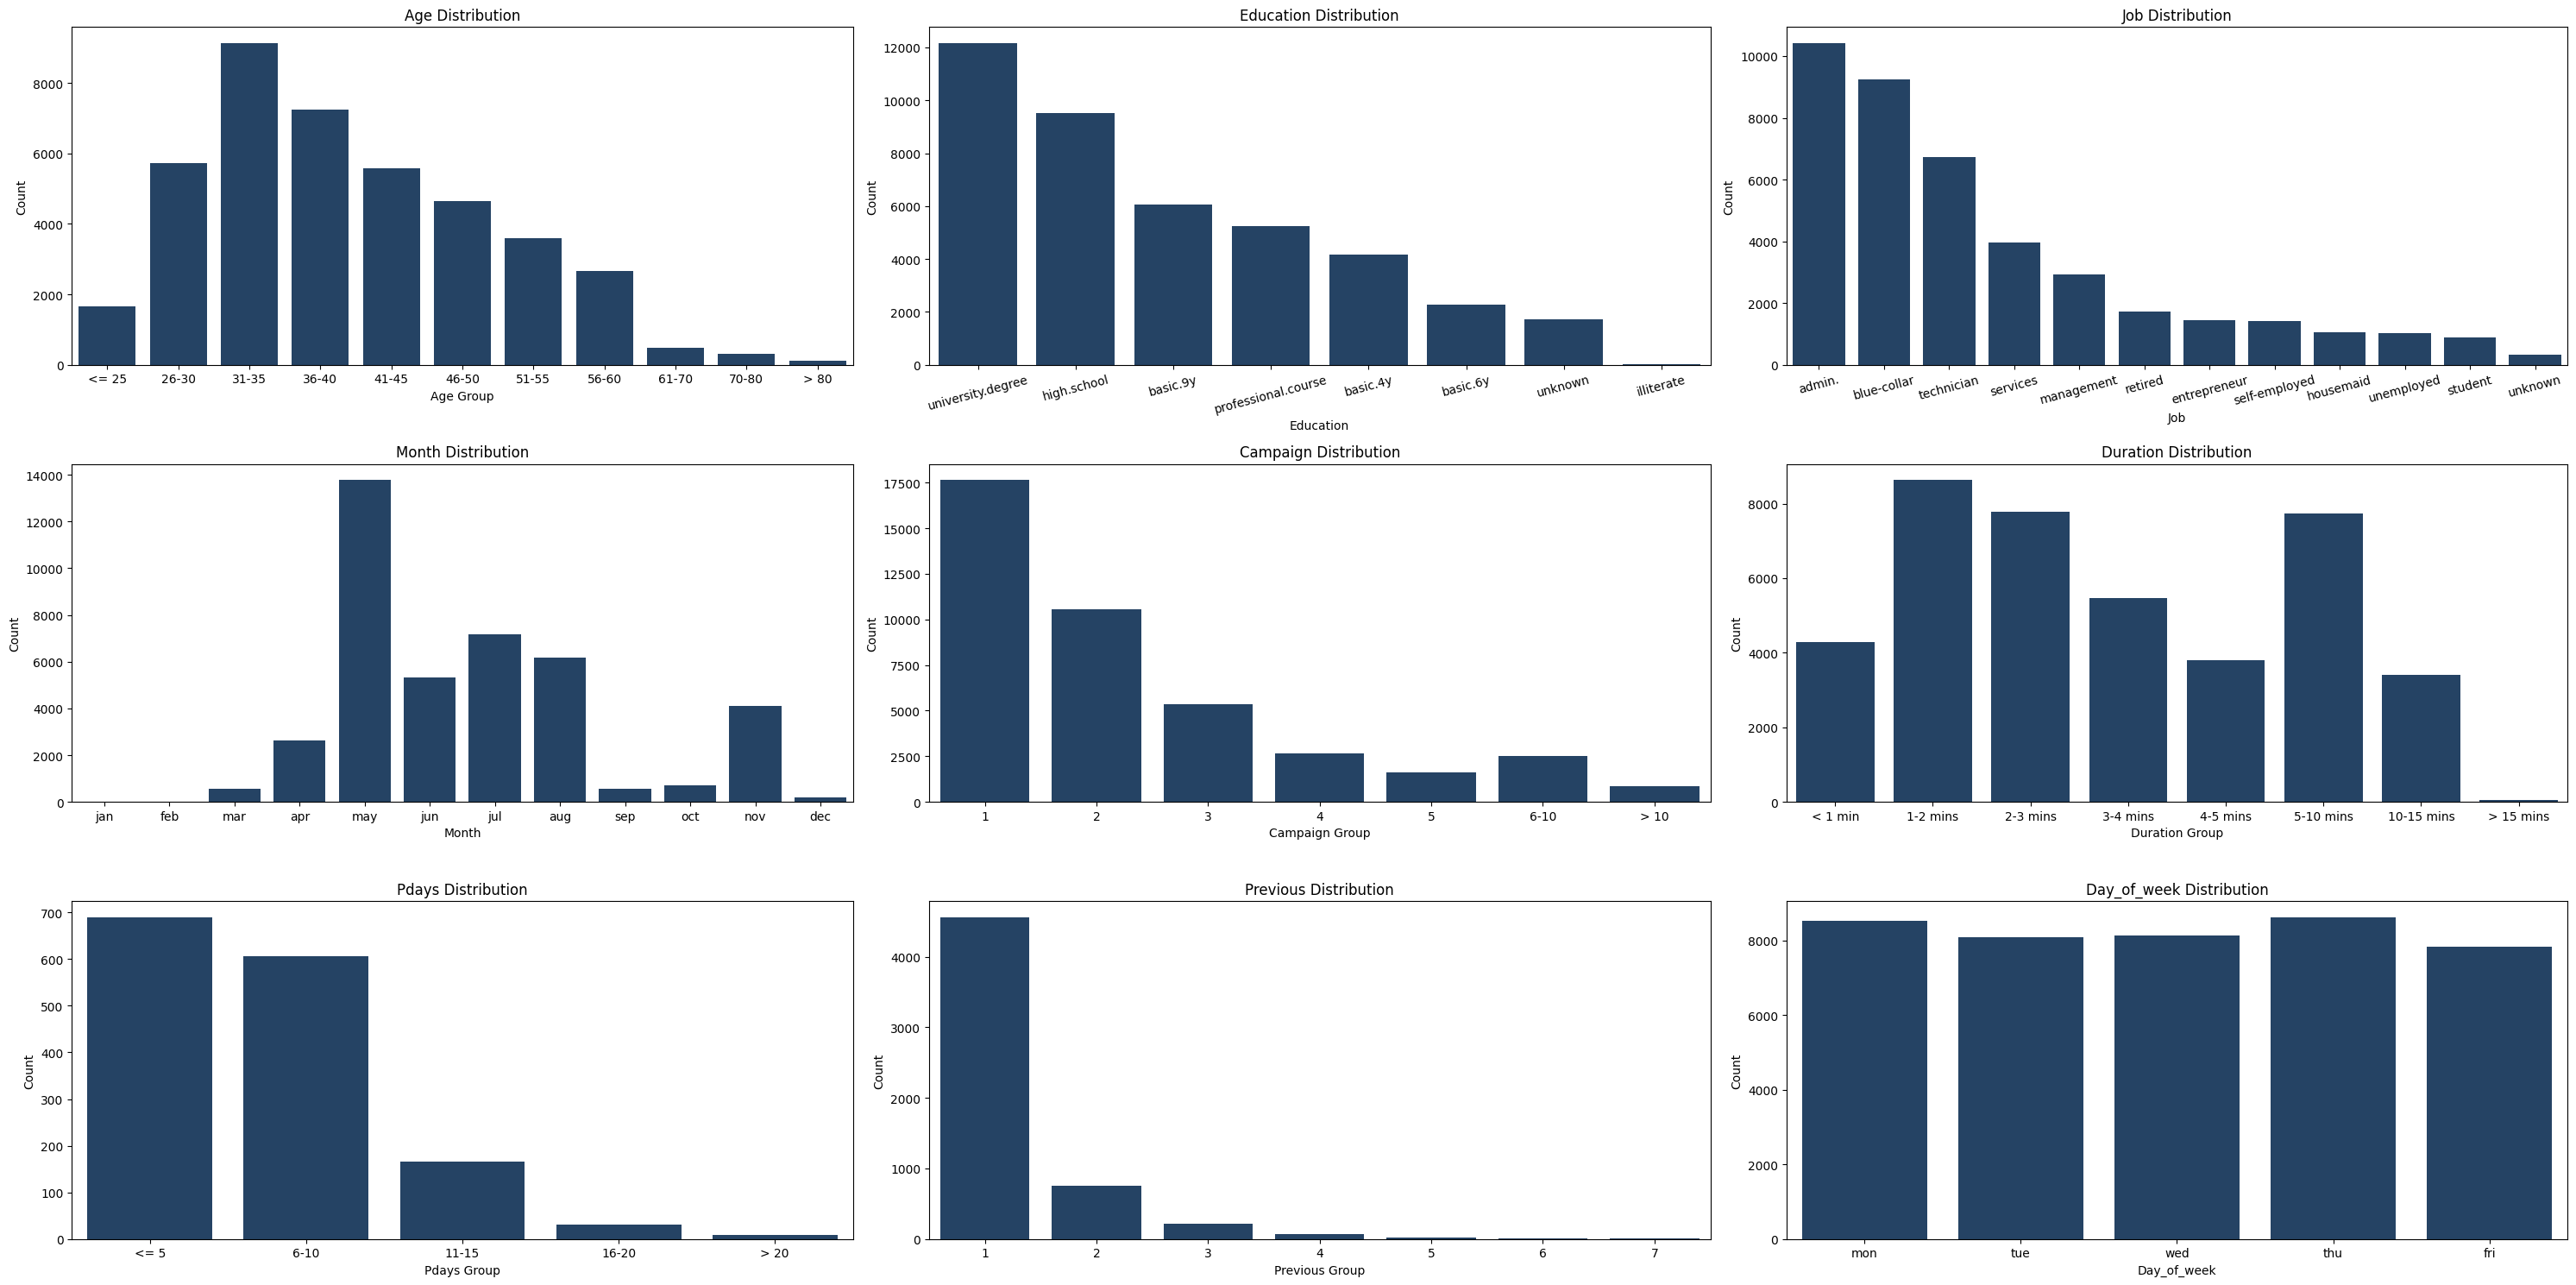

In [16]:
cate1 = {
    'age': {
        'bins': [0, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, float('inf')],
        'labels': ['<= 25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-70', '70-80', '> 80']
    },
    'duration': {
        'bins': [0, 60, 120, 180, 240, 300, 600, 2000, float('inf')],
        'labels': ['< 1 min', '1-2 mins', '2-3 mins', '3-4 mins', '4-5 mins', '5-10 mins', '10-15 mins', '> 15 mins']
    },
    'pdays': {
        'bins': [0, 5, 10, 15, 20, 500],
        'labels': ['<= 5', '6-10', '11-15', '16-20', '> 20']
    },
    'campaign': {
        'bins': [0, 1, 2, 3, 4, 5, 10, float('inf')],
        'labels': ['1', '2', '3', '4', '5', '6-10', '> 10']
    },
    'previous': {
        'bins': [0, 1, 2, 3, 4, 5, 6, 7],
        'labels': ['1', '2', '3', '4', '5', '6', '7']
    }
}

cate2 = ['job', 'education', 'month', 'day_of_week']

order_of_graph = ['age', 'education', 'job', 'month', 'campaign', 'duration', 'pdays', 'previous', 'day_of_week']
position = {attr: i for i, attr in enumerate(order_of_graph, 1)}

plt.figure(figsize=(30, 15))

for attr in cate1.keys():
    plt.subplot(3, 3, position[attr])
    data_vis[attr] = pd.cut(data_vis[attr], bins=cate1[attr]['bins'], labels=cate1[attr]['labels'], right=True)
    data_group = data_vis.groupby(attr, observed=False).size().reset_index(name='count')
    sns.barplot(x=attr, y='count', data=data_group, color='#1B436E')
    plt.title(f'{attr.capitalize()} Distribution')
    plt.xlabel(f'{attr.capitalize()} Group')
    plt.ylabel('Count')

for attr in cate2:
    plt.subplot(3, 3, position[attr])
    if attr in ['job', 'education']:
        data_group = data_vis.groupby(attr, observed=False).size().reset_index(name='count').sort_values(by='count', ascending=False)
    else:
        order = {
            'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
            'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri'],
            'education': ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'university.degree', 'professional.course']
        }
        data_vis[attr] = pd.Categorical(data_vis[attr], categories=order[attr], ordered=True)
        data_group = data_vis.groupby(attr, observed=False).size().reset_index(name='count')

    sns.barplot(x=attr, y='count', data=data_group, color='#1B436E')
    plt.title(f'{attr.capitalize()} Distribution')
    plt.xlabel(attr.capitalize())
    plt.ylabel('Count')
    if attr in ['job', 'education']:
        plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


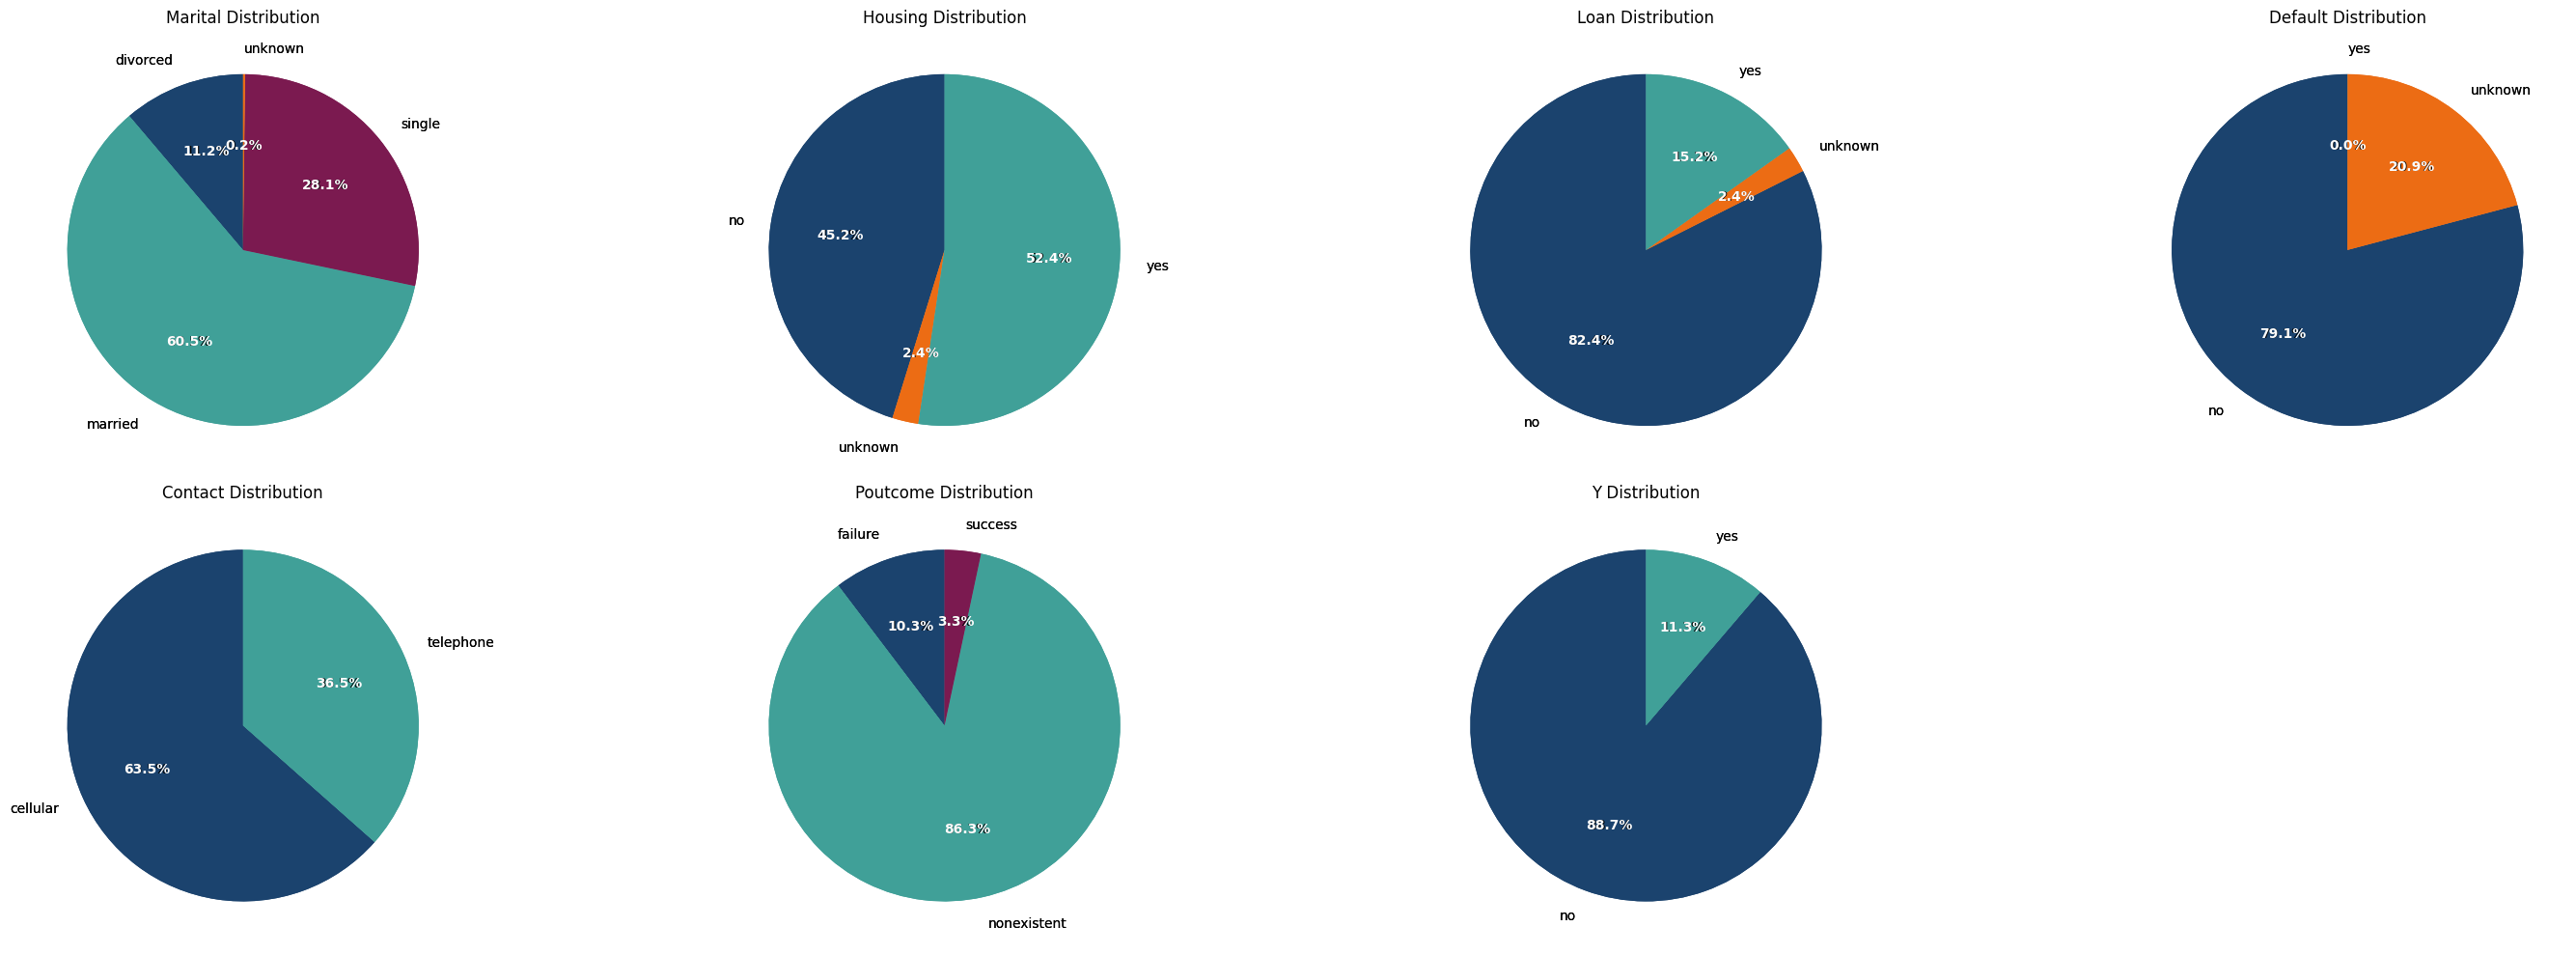

In [17]:
cate = ['marital', 'housing', 'loan', 'default', 'contact', 'poutcome', 'y']
plt.figure(figsize=(30, 10))
colors = ['#1B436E', '#40A098', '#7B1A50', ]

for i, attr in enumerate(cate, 1):
    plt.subplot(2, 4, i)
    data_job = data_vis.groupby([attr]).size().reset_index(name='count')
    colors = ['#1B436E', '#40A098', '#7B1A50', '#EC6C14']
    if 'unknown' in data_job[attr].values.tolist():
        idx = data_job[attr].values.tolist().index('unknown')
        colors_chart = colors[:idx] + ['#EC6C14'] + colors[idx:]
    else:
        colors_chart = colors
    plt.pie(data_job['count'], labels=data_job[attr], autopct='%1.1f%%',
          pctdistance=0.6, labeldistance=1.15, startangle=90, colors = colors_chart)
          # textprops={'color': 'white', 'fontweight': 'bold'})
    _, _, autotexts =  plt.pie(data_job['count'], labels=data_job[attr], autopct='%1.1f%%',
          pctdistance=0.6, labeldistance=1.15, startangle=90, colors = colors_chart)
    for autotext in autotexts:
      autotext.set_color('white')
      autotext.set_fontweight('bold')

    plt.title(f'{attr.capitalize()} Distribution')

plt.tight_layout()
plt.show()


### Summary

**CURRENT CAMPAIGN'S CLIENTS:**

1.   Age: 26 - 45
2.   Education: University's degree or high school
3.   Job: Admin or Blue-collar, technician
1.   Marital: Married
2.   Housing: Yes
3.   Loan: No


**CURRENT CAMPAIGN'S APPROACH:**
1.   Time: May
2.   Number of contact made: 1 - 2
3.   Duration: 1 - 3 mins or 5 - 10 mins
4.   Time interval from last call: 0 - 10 days
5.   Contact: Cellular
2.   Outcome: Mostly No but success increased 8%

Note: From the above distribution we can be sure that the data is imbalanced, as the number of 'no's are also 8 times the number of 'yes'


## D.Bivariate/Multivariate Analysis

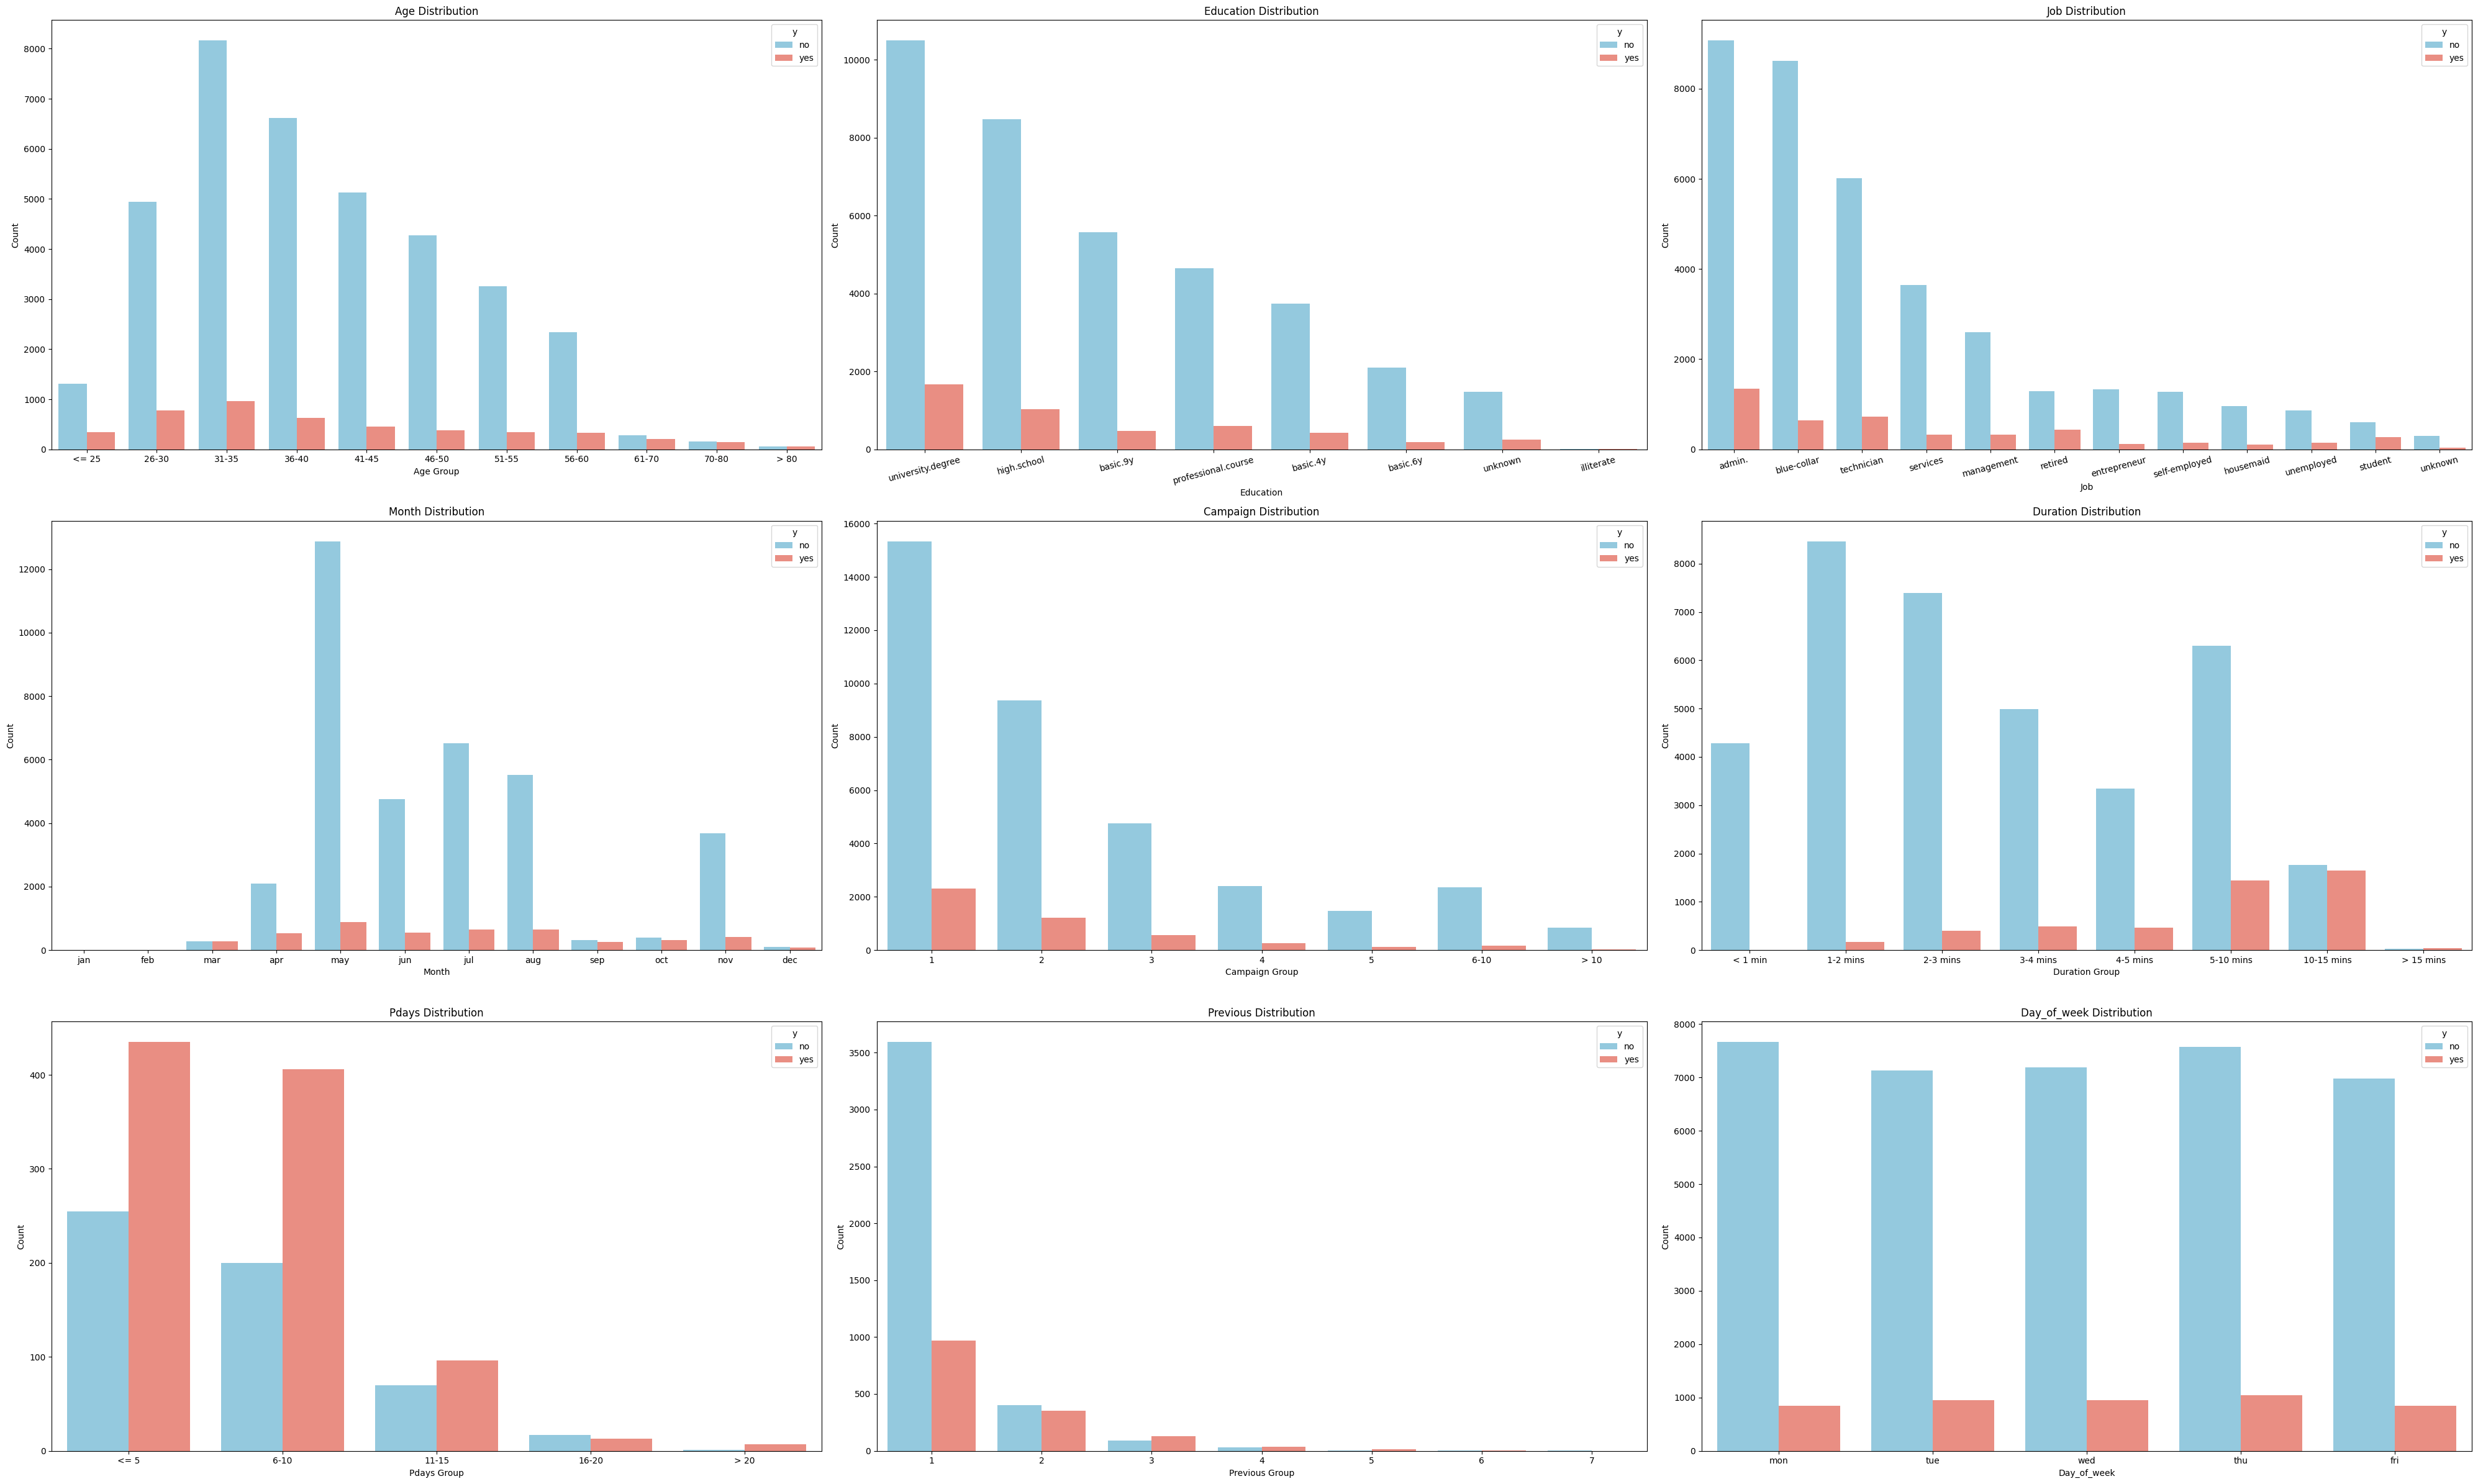

In [18]:
plt.figure(figsize=(4*10, 3*8))

for attr in cate1.keys():
    plt.subplot(3, 3, position[attr])
    sns.countplot(x=attr, hue='y', data=data_vis, palette=['skyblue', 'salmon'])
    plt.title(f'{attr.capitalize()} Distribution')
    plt.xlabel(f'{attr.capitalize()} Group')
    plt.ylabel('Count')

for attr in cate2:
    plt.subplot(3, 3, position[attr])
    if attr in ['job', 'education']:
        data_group = data_vis[attr].value_counts().reset_index()
        data_group.columns = [attr, 'count']
        order = data_group[attr].tolist()
    else:
        order = {
            'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
            'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri'],
            'education': ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'university.degree', 'professional.course']
        }[attr]

    sns.countplot(x=attr, hue='y', data=data_vis, order=order, palette=['skyblue', 'salmon'])
    plt.title(f'{attr.capitalize()} Distribution')
    plt.xlabel(attr.capitalize())
    plt.ylabel('Count')

    if attr in ['job', 'education']:
        plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


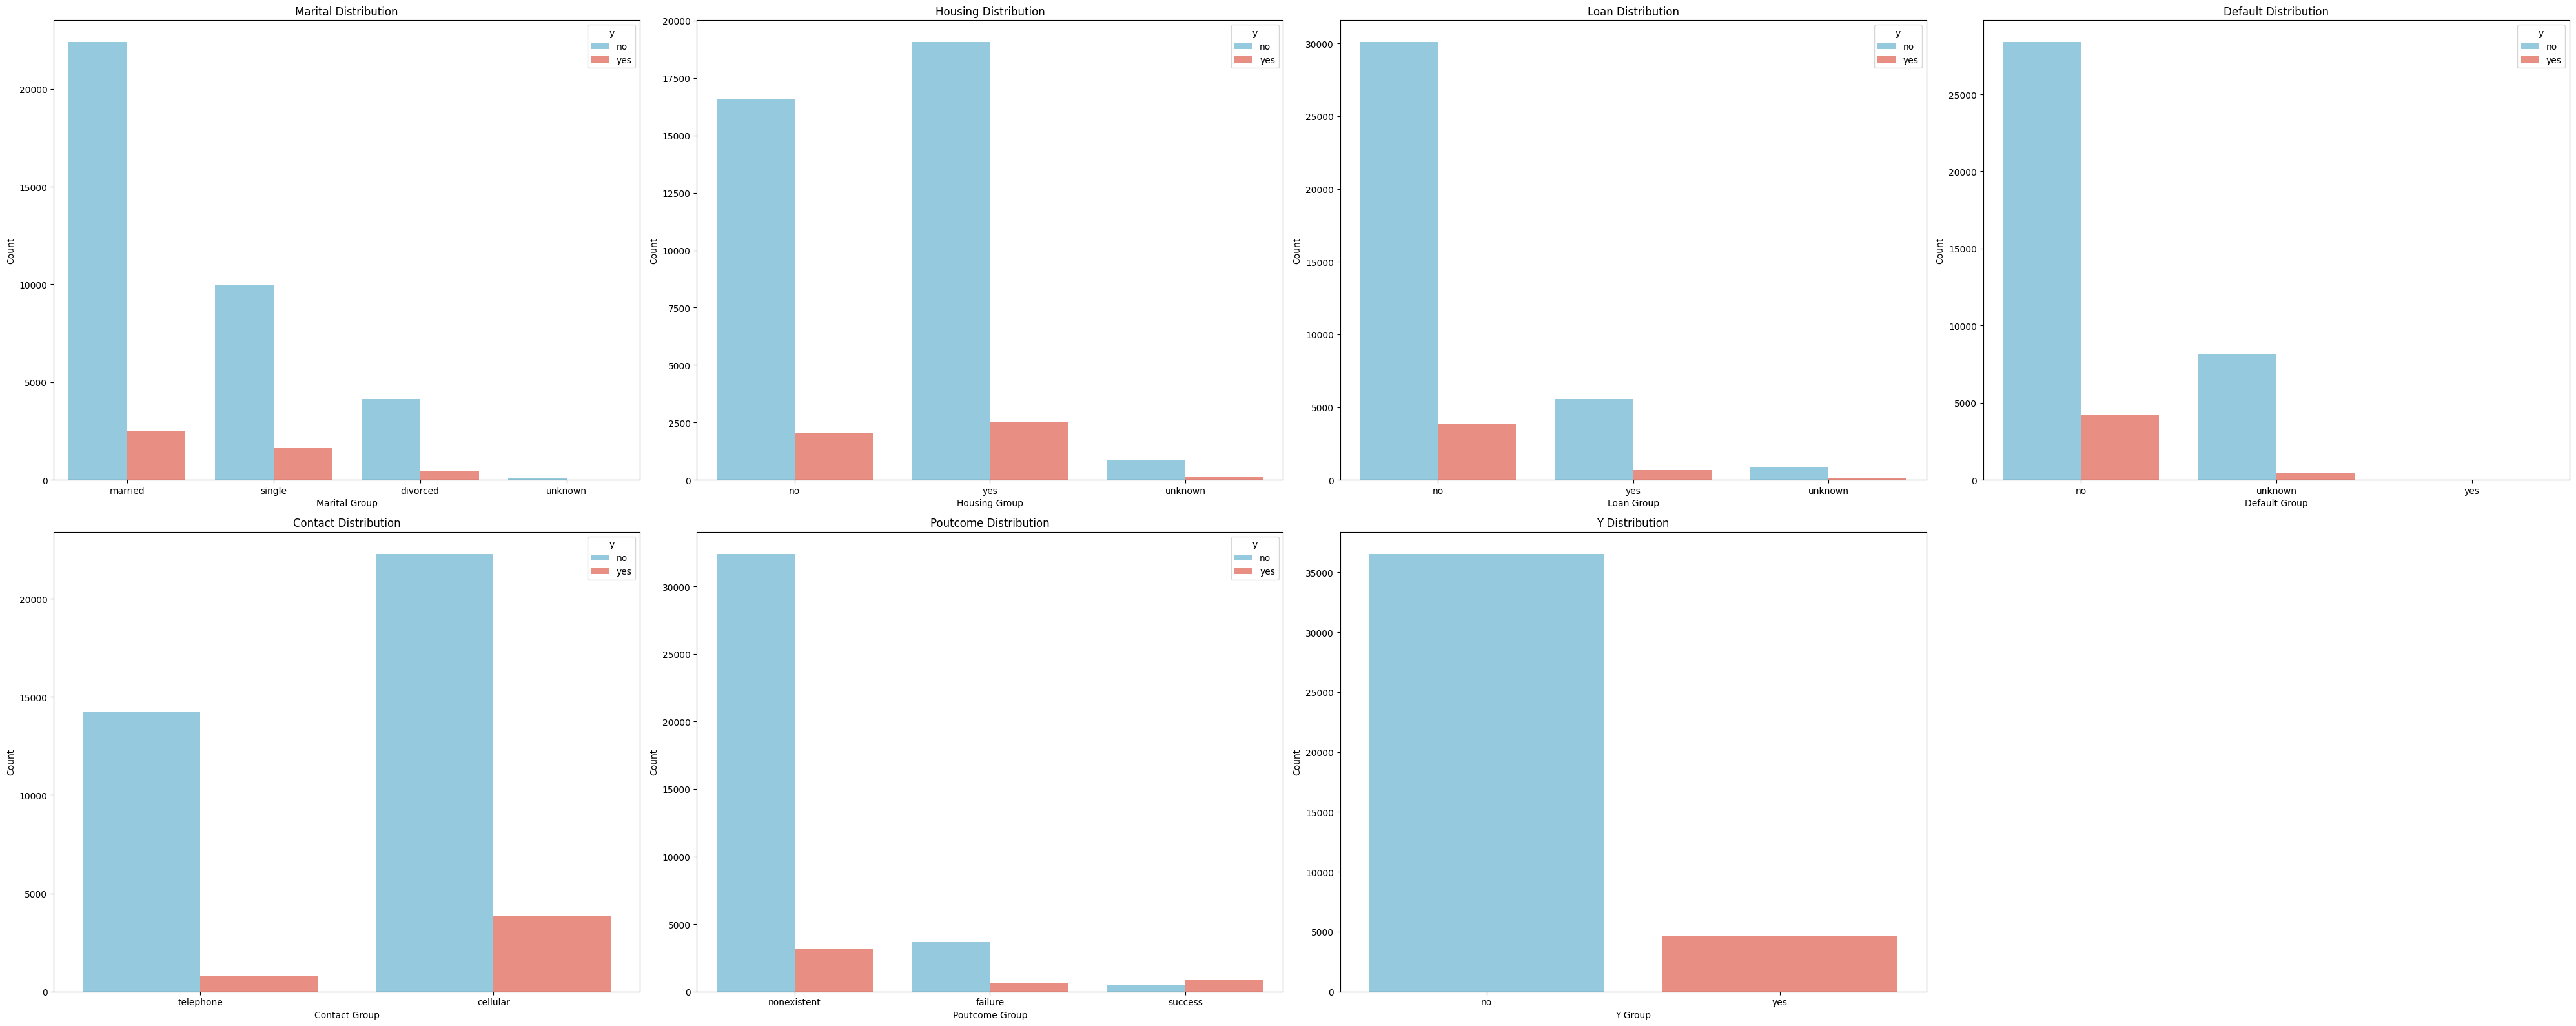

In [19]:
plt.figure(figsize=(4*10, 2*8))

for i, attr in enumerate(cate, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=attr, hue='y', data=data_vis, palette=['skyblue', 'salmon'])
    plt.title(f'{attr.capitalize()} Distribution')
    plt.xlabel(f'{attr.capitalize()} Group')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

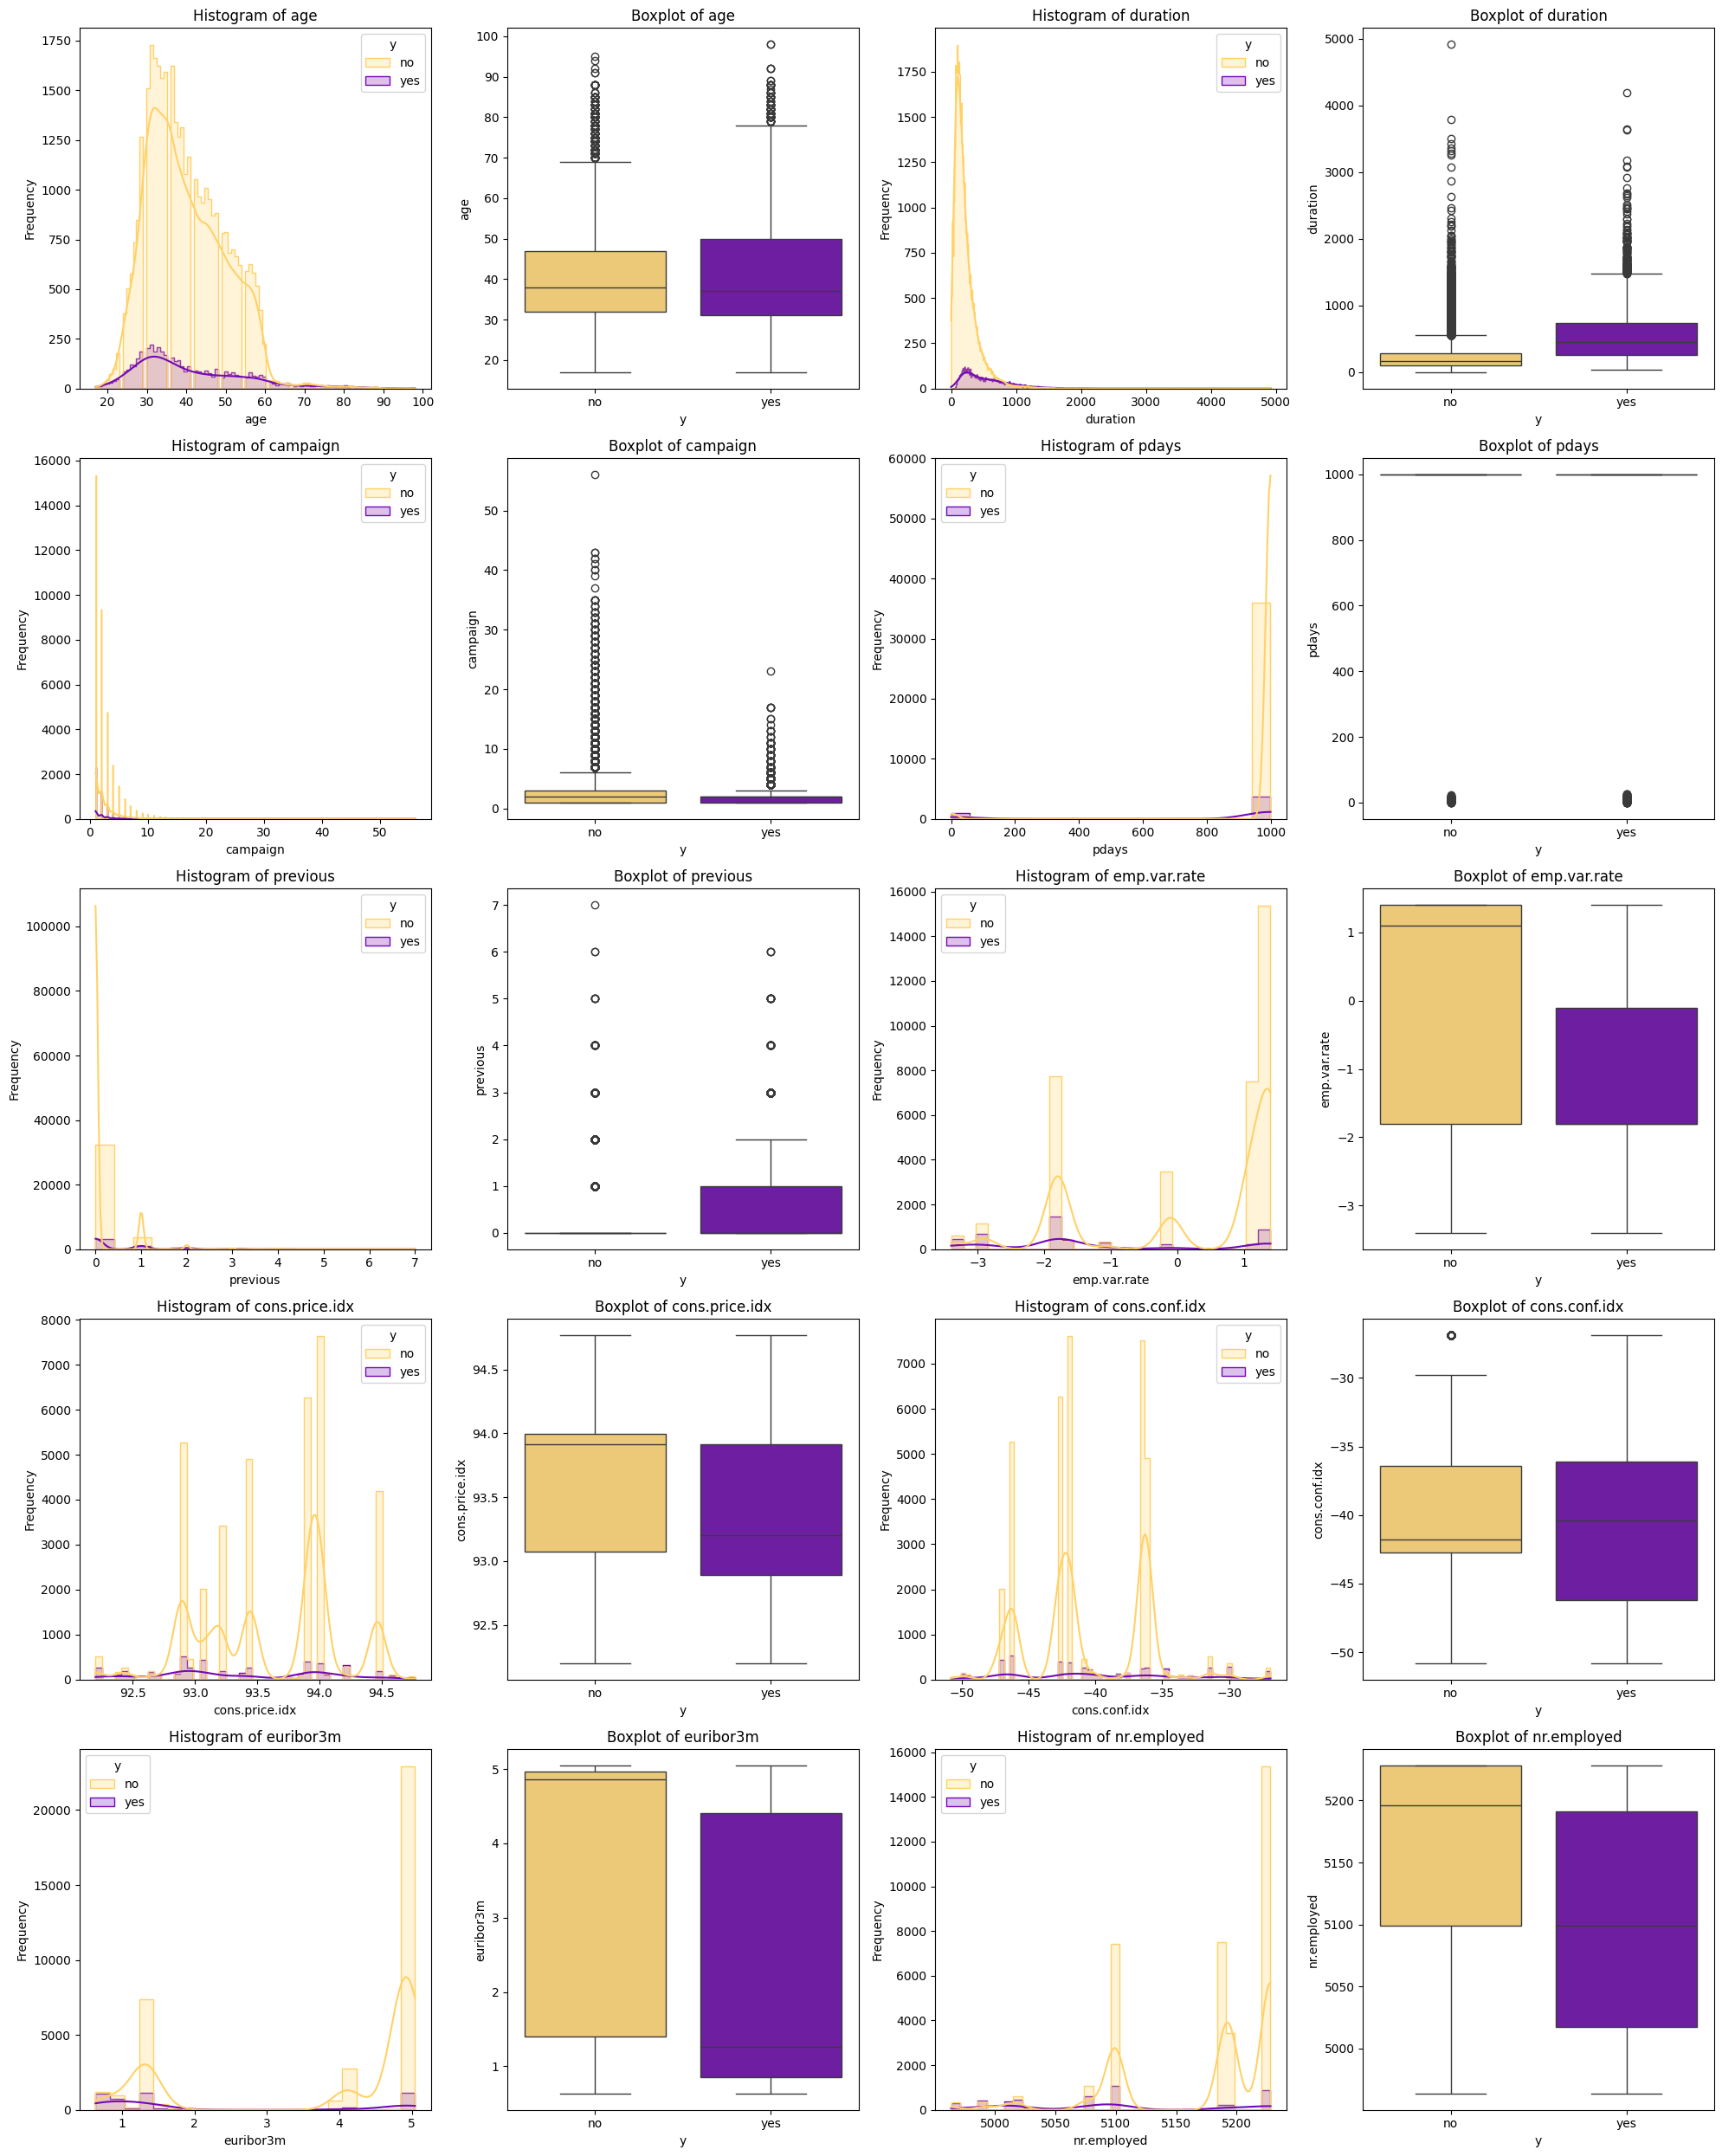

In [20]:
plt.figure(figsize=(5*4, 5*5))

for i, attr in enumerate(num_col, 1):

    plt.subplot(5, 4, 2*(i-1) + 1)
    sns.histplot(data=data, x=attr, hue='y', kde=True,
        element='step', common_norm=False, palette={'yes': '#7209B7', 'no': '#FFD166'}
    )
    plt.title(f'Histogram of {attr}')
    plt.ylabel('Frequency')

    plt.subplot(5, 4, 2*(i-1) + 2)
    sns.boxplot(data=data, x='y', y=attr, hue='y', palette={'yes': '#7209B7', 'no': '#FFD166'} )
    plt.title(f'Boxplot of {attr}')
    plt.xlabel('y')

plt.tight_layout()
plt.show()


**We can consider some following questions:**

1.   What is the target customers of this campaign?


2.   What is the potential approach of the campaign?


3. How the economy affect clients' decision?






### 1.What is the target/ potential customers of this campaign?

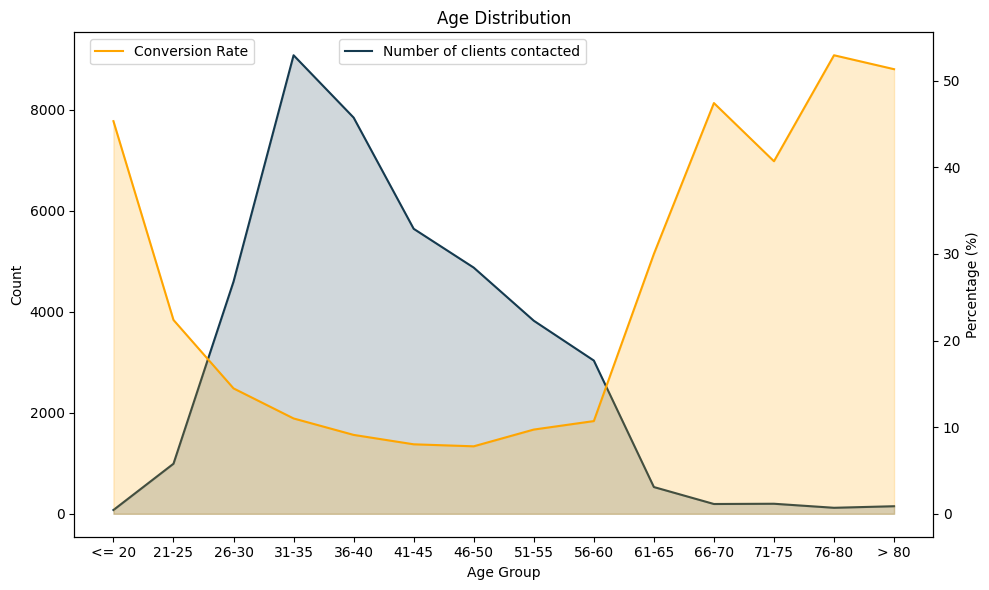

In [21]:
data_target = data[['age', 'y']].groupby(['age', 'y'], observed=False).size().reset_index(name='count')
data_target_pivot = data_target.pivot(index='age', columns='y', values='count').fillna(0)
data_target_pivot['total'] = data_target_pivot['yes'] + data_target_pivot['no']
data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, float('inf')]
labels = ['<= 20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '> 80']

data_target_pivot['age_group'] = pd.cut(data_target_pivot.index, bins=bins, labels=labels, right=False)
data_target_pivot = data_target_pivot.groupby('age_group', observed=False).sum()
data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100
data_target_pivot.reset_index(inplace=True)

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data_target_pivot.age_group, data_target_pivot['total'], color='#153A4F')
ax1.fill_between(data_target_pivot.age_group, data_target_pivot['total'], color='#153A4F', alpha=.2)
ax1.set_ylabel('Count')
ax1.set_xlabel('Age Group')
ax1.legend(['Number of clients contacted'], loc='upper left', bbox_to_anchor=(0.3, 1), ncol=2)

ax2 = ax1.twinx()
ax2.plot(data_target_pivot.age_group, data_target_pivot['percent_yes'], color='orange')
ax2.fill_between(data_target_pivot.age_group, data_target_pivot['percent_yes'], color='orange', alpha=.2)
ax2.set_ylabel('Percentage (%)')
ax2.legend(['Conversion Rate'], loc='upper left', bbox_to_anchor=(0.01, 1), ncol=2)
plt.title('Age Distribution')
plt.tight_layout()

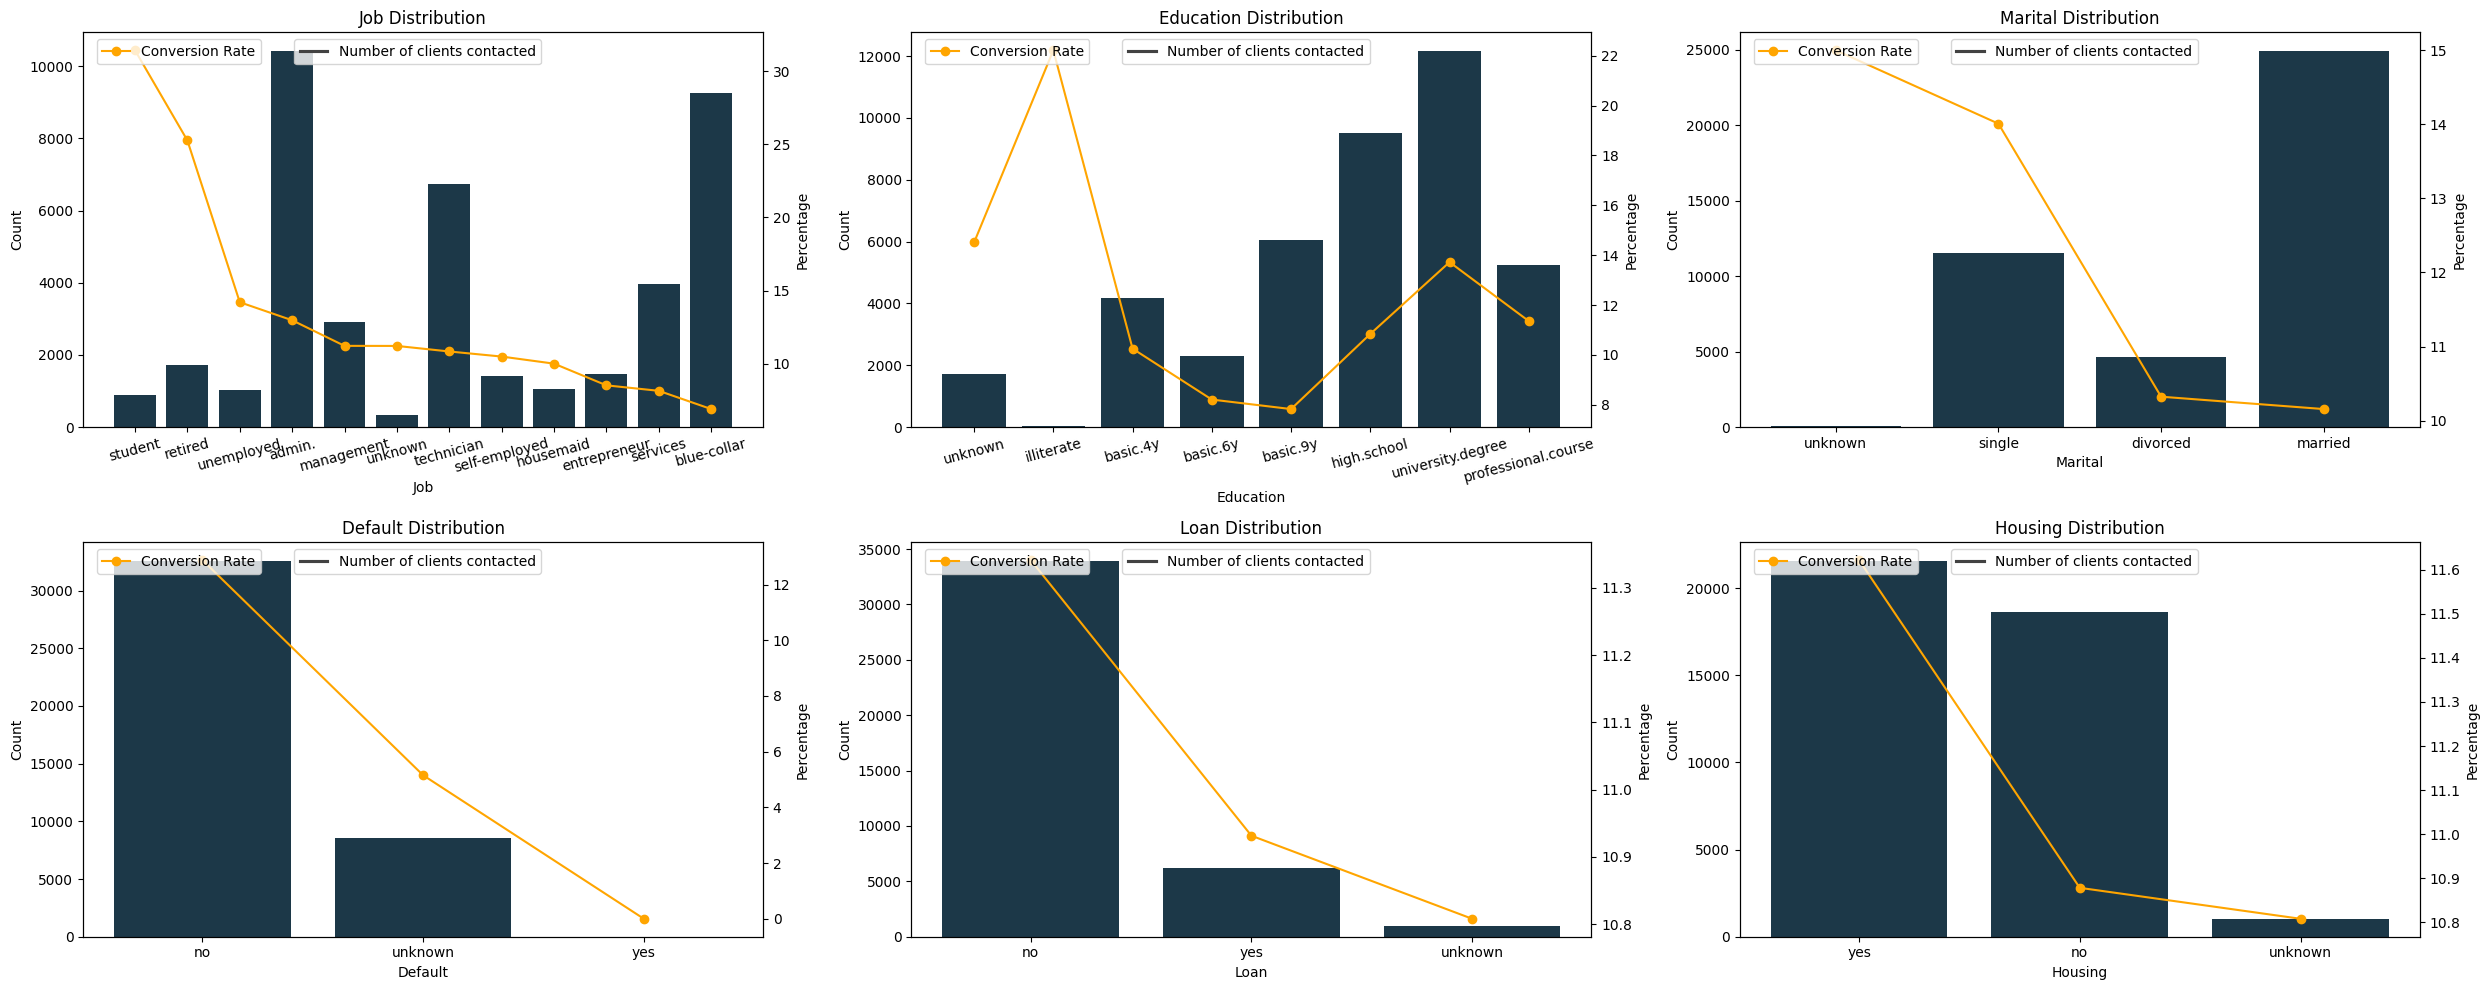

In [22]:
cate2 = ['job', 'education', 'marital', 'default', 'loan', 'housing']

plt.figure(figsize=(25, 10))

for i, attr in enumerate(cate2, 1):
    plt.subplot(2, 3, i)
    data_target = data[[attr, 'y']].groupby([attr, 'y']).size().reset_index(name='count')
    data_target_pivot = data_target.pivot(index=attr, columns='y', values='count').fillna(0)
    data_target_pivot['total'] = data_target_pivot['yes'] + data_target_pivot['no']
    data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100
    data_target_pivot = data_target_pivot.sort_values(by='percent_yes', ascending=False)
    data_target_pivot.reset_index(inplace=True)
    if attr == 'education':
        order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'university.degree', 'professional.course']
        data_target_pivot[attr] = pd.Categorical(data_target_pivot[attr], categories=order, ordered=True)
        data_target_pivot = data_target_pivot.sort_values(by=attr)

    # Plot twin chart
    ax1 = sns.barplot(x=data_target_pivot[attr], y='total', data=data_target_pivot, color='#153A4F')
    ax1.set_ylabel('Count')
    ax1.set_xlabel(attr.capitalize())
    ax1.legend(['Number of clients contacted'], loc='upper left', bbox_to_anchor=(0.3, 1), ncol=2)

    ax2 = ax1.twinx()
    ax2.plot(data_target_pivot[attr], data_target_pivot['percent_yes'], color='orange', marker='o')
    ax2.set_ylabel('Percentage')
    ax2.yaxis.grid(False)
    ax2.legend(['Conversion Rate'], loc='upper left', bbox_to_anchor=(0.01, 1), ncol=2)

    if attr in ['job', 'education']:
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15)
    plt.title(f'{attr.capitalize()} Distribution')

plt.tight_layout()
plt.show()

The remaining graphs provide valuable insights into different customer segments:

- **Age graph**: Looking at the yellow line, the conversion rate (CR) for the ≤25 and >60 age groups is significantly higher than for the 26-60 group. However, the blue line shows that the number of people in the high-CR groups is very low, making the data prone to bias.
The low CR of the 26-60 group is likely due to the majority of the population being within this age range, reducing the risk of bias. We should expand and target the ≤25 and >60 age segments in the next campaign. However, in addition to reaching these new segments, the campaign should also focus on improving quality to increase the CR of the primary customer group (26-60).

- **Job**: While students and retirees have high conversion rates, their numbers are too low to be a primary focus. On the other hand, admin and technician roles stand out as promising segments due to both their relatively high conversion rates and large customer base. Additionally, management shows a strong conversion rate but with a smaller audience compared to the previous two. This trend is likely because admin and technician roles typically offer stable, mid-to-high incomes, making them more inclined to save.

- **Education**: Customers with a university degree are a key target group, as they not only represent a large portion of the dataset (> 12,000) but also have a high conversion rate (~14%). Higher education levels may correlate with better financial awareness and higher income, leading to greater interest in financial products.

- **Marital**: The single group has a strong conversion rate, but they are not the primary target of the campaign. In contrast, the married group has a lower conversion rate but forms the core customer base. This is likely because single individuals make independent financial decisions, while married individuals dominate the population within the key 26-60 age range.

- **Default** & **Loan**: Customers without credit debt have both the highest numbers and conversion rates, likely due to their stable financial situation. The same pattern applies to those without personal loans.

- **Housing**: In contrast to *loan* and *default*, individuals with a housing loan not only make up a significant portion of the dataset but also exhibit the highest conversion rate. This could be due to financial pressure from mortgage payments, motivating them to seek investment or savings opportunities like term deposits.

**Summary & Campaign Improvement Suggestions**

**Target Customer Profile**:
- **Age**: 26 - 60
- **Job**: Admin, technician
- **Education**: University.degree
- **Marital**: Married
- **Default**: No
- **Loan**: No
- **Housing**: Yes
These characteristics define the ideal target audience for the next campaign. However, expansion into other potential segments, such as individuals under 25 and over 60 or those in management roles, should also be considered.
---
**Suggestions for Campaign Improvement**:
- **Age**: 
    - For 26-60: Develop in-depth marketing content emphasizing financial products and the benefits of long-term saving and investing
    - For <= 25: Leverage social media and online channels to engage and reach this audience
- **Job**:
    - Design tailored savings or investment programs aligned with the income levels of admins and technicians
    - Expand outreach to the management sector to explore its potential
- **Education**:
    - Offer specialized financial products for university degree holders, such as preferential interest rates on term deposits
- **Married Individuals**: 
    - Introduce financial solutions designed for married customers, including joint financial management options for families
- **Default** & **Loan** (Customers Without Debt):
    - Create marketing content emphasizing financial stability and the benefits of sound personal finance management
- **Housing Loan Holders**:
    - Provide flexible financial solutions to help them manage loans and related expenses more effectively

### 2.What is the potential approach of the campaign?

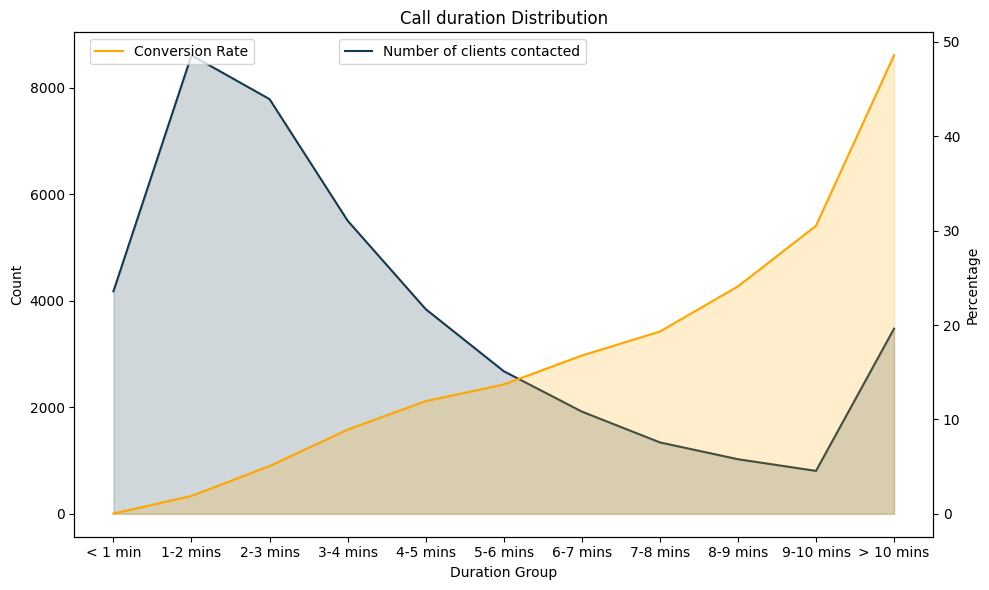

In [23]:
data_target = data[['duration', 'y']].groupby(['duration', 'y']).size().reset_index(name='count')
data_target_pivot = data_target.pivot(index='duration', columns='y', values='count').fillna(0)
data_target_pivot['total'] = data_target_pivot['yes'] + data_target_pivot['no']
data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100

bins = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, float('inf')]
labels = ['< 1 min', '1-2 mins', '2-3 mins', '3-4 mins', '4-5 mins', '5-6 mins', '6-7 mins', '7-8 mins', '8-9 mins', '9-10 mins', '> 10 mins']

data_target_pivot['duration_group'] = pd.cut(data_target_pivot.index, bins=bins, labels=labels, right=False)
data_target_pivot = data_target_pivot.groupby('duration_group', observed=False).sum()
data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100
data_target_pivot.reset_index(inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data_target_pivot.duration_group, data_target_pivot['total'], color='#153A4F')
ax1.fill_between(data_target_pivot.duration_group, data_target_pivot['total'], color='#153A4F', alpha=.2)
ax1.set_ylabel('Count')
ax1.set_xlabel('Duration Group')
ax1.legend(['Number of clients contacted'], loc='upper left', bbox_to_anchor=(0.3, 1), ncol=2)

ax2 = ax1.twinx()
ax2.plot(data_target_pivot.duration_group, data_target_pivot['percent_yes'], color='orange')
ax2.fill_between(data_target_pivot.duration_group, data_target_pivot['percent_yes'], color='orange', alpha=.2)
ax2.set_ylabel('Percentage')
ax2.legend(['Conversion Rate'], loc='upper left', bbox_to_anchor=(0.01, 1), ncol=2)
ax2.yaxis.grid(False)
plt.title('Call duration Distribution')
plt.tight_layout()

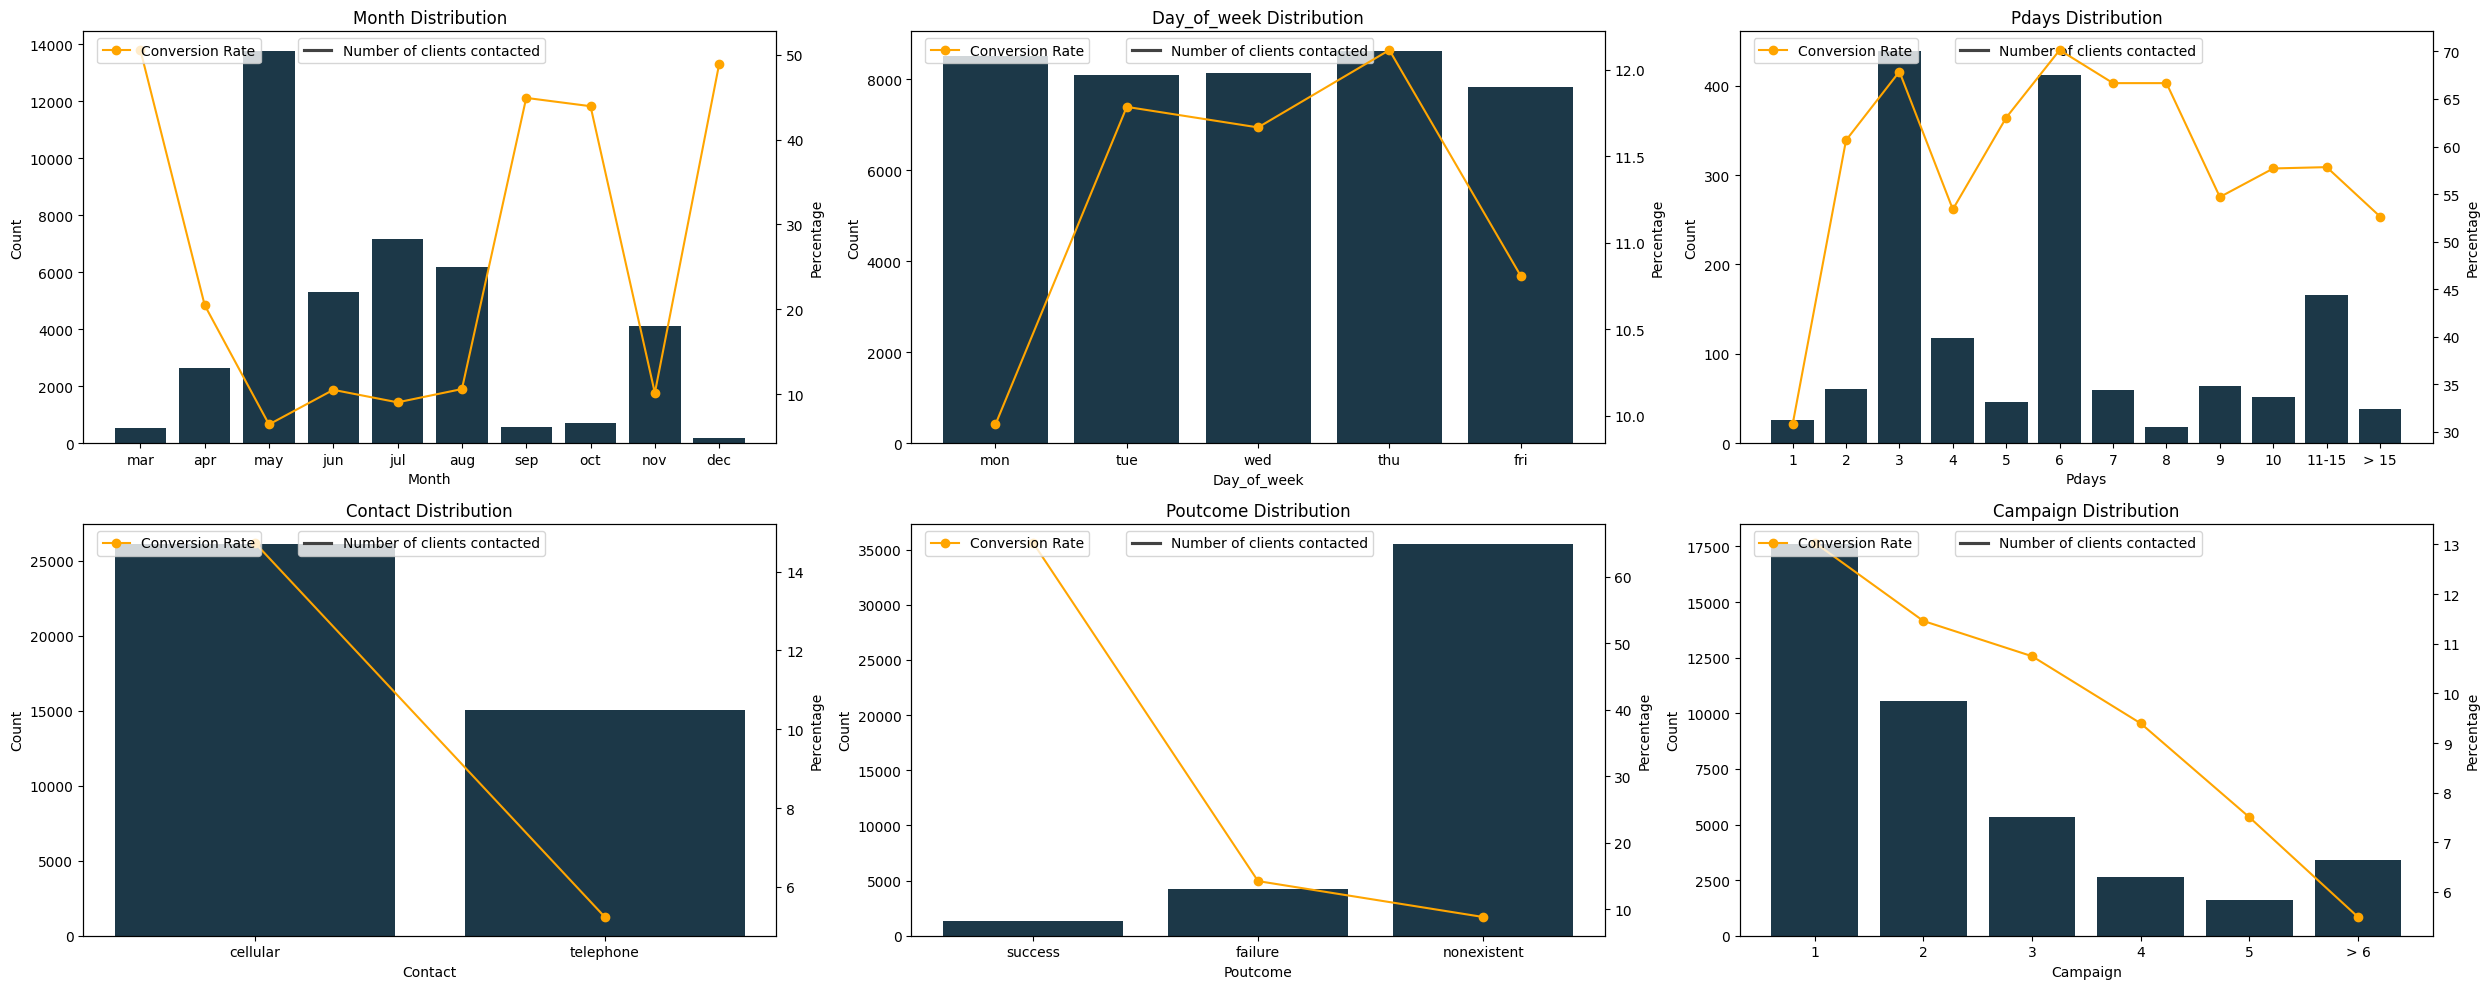

In [24]:
cate2 = ['month', 'day_of_week', 'pdays', 'contact', 'poutcome', 'campaign']

plt.figure(figsize=(25, 10))
plt.subplots_adjust(top=1.25, bottom=0.1, hspace=0.5, wspace=0.3)

for i, attr in enumerate(cate2, 1):
    plt.subplot(2, 3, i)
    data_target = data[[attr, 'y']].groupby([attr, 'y'], observed=False).size().reset_index(name='count')
    data_target_pivot = data_target.pivot(index=attr, columns='y', values='count').fillna(0)
    data_target_pivot['total'] = data_target_pivot['yes'] + data_target_pivot['no']
    data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100
    data_target_pivot = data_target_pivot.sort_values(by='percent_yes', ascending=False)
    data_target_pivot.reset_index(inplace=True)

    if attr in ['pdays', 'campaign']:
        cate = {'pdays' : {
                'bins':[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 500],
                'labels':['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '> 15']},
                'campaign' : {
                'bins':[0, 1, 2, 3, 4, 5, float('inf')],
                'labels': ['1', '2', '3', '4', '5', '> 6']}}
        data_target_pivot[attr] = pd.cut(data_target_pivot[attr], bins=cate[attr]['bins'], labels=cate[attr]['labels'], right=True)
        data_target_pivot = data_target_pivot.groupby(attr, observed=False).sum()
        data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100
        data_target_pivot.reset_index(inplace=True)

    if attr in ['month', 'day_of_week', 'previous']:
        order = {'month':['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                'day_of_week':['mon', 'tue', 'wed', 'thu', 'fri'],
                'previous':[0, 1, 2, 3, 4, 5, 6, 7],}
        data_target_pivot[attr] = pd.Categorical(data_target_pivot[attr], categories=order[attr], ordered=True)
        data_target_pivot = data_target_pivot.sort_values(by=attr)

    # Plot twin chart
    ax1 = sns.barplot(x=data_target_pivot[attr], y='total', data=data_target_pivot, color='#153A4F')
    ax1.set_ylabel('Count')
    ax1.set_xlabel(attr.capitalize())
    ax1.legend(['Number of clients contacted'], loc='upper left', bbox_to_anchor=(0.3, 1), ncol=2)

    ax2 = ax1.twinx()
    ax2.plot(data_target_pivot[attr], data_target_pivot['percent_yes'], color='orange', marker='o')
    ax2.set_ylabel('Percentage')
    ax2.yaxis.grid(False)
    ax2.legend(['Conversion Rate'], loc='upper left', bbox_to_anchor=(0.01, 1), ncol=2)

    plt.title(f'{attr.capitalize()} Distribution')

plt.tight_layout()
plt.show()

**Insights from Additional Graphs**
- **Duration**: The length of the call is directly proportional to the conversion rate, indicating that call duration plays a crucial role in the customer’s decision-making process.
- **Pdays**: There is a noticeable spike in conversion rates at pdays = 3 and 6, and these two groups also have the highest customer count. This suggests that customers are more likely to sign up when contacted again after three or six days, likely because they have had sufficient time to consider their decision.
- **Contact**: Customers reached via cellular phones have conversion rates and numbers twice as high as those contacted via landline phones. This could be due to the convenience of mobile phones and their higher reach among financially capable individuals.
- **Campaign**: Conversion rates decrease as the number of contact attempts increases. The highest conversion rate is seen in customers contacted only once, suggesting that excessive follow-ups may feel intrusive or annoying, whereas a single well-executed call can leave a positive impression and drive action.

### 3.How the economy affect clients' decision?

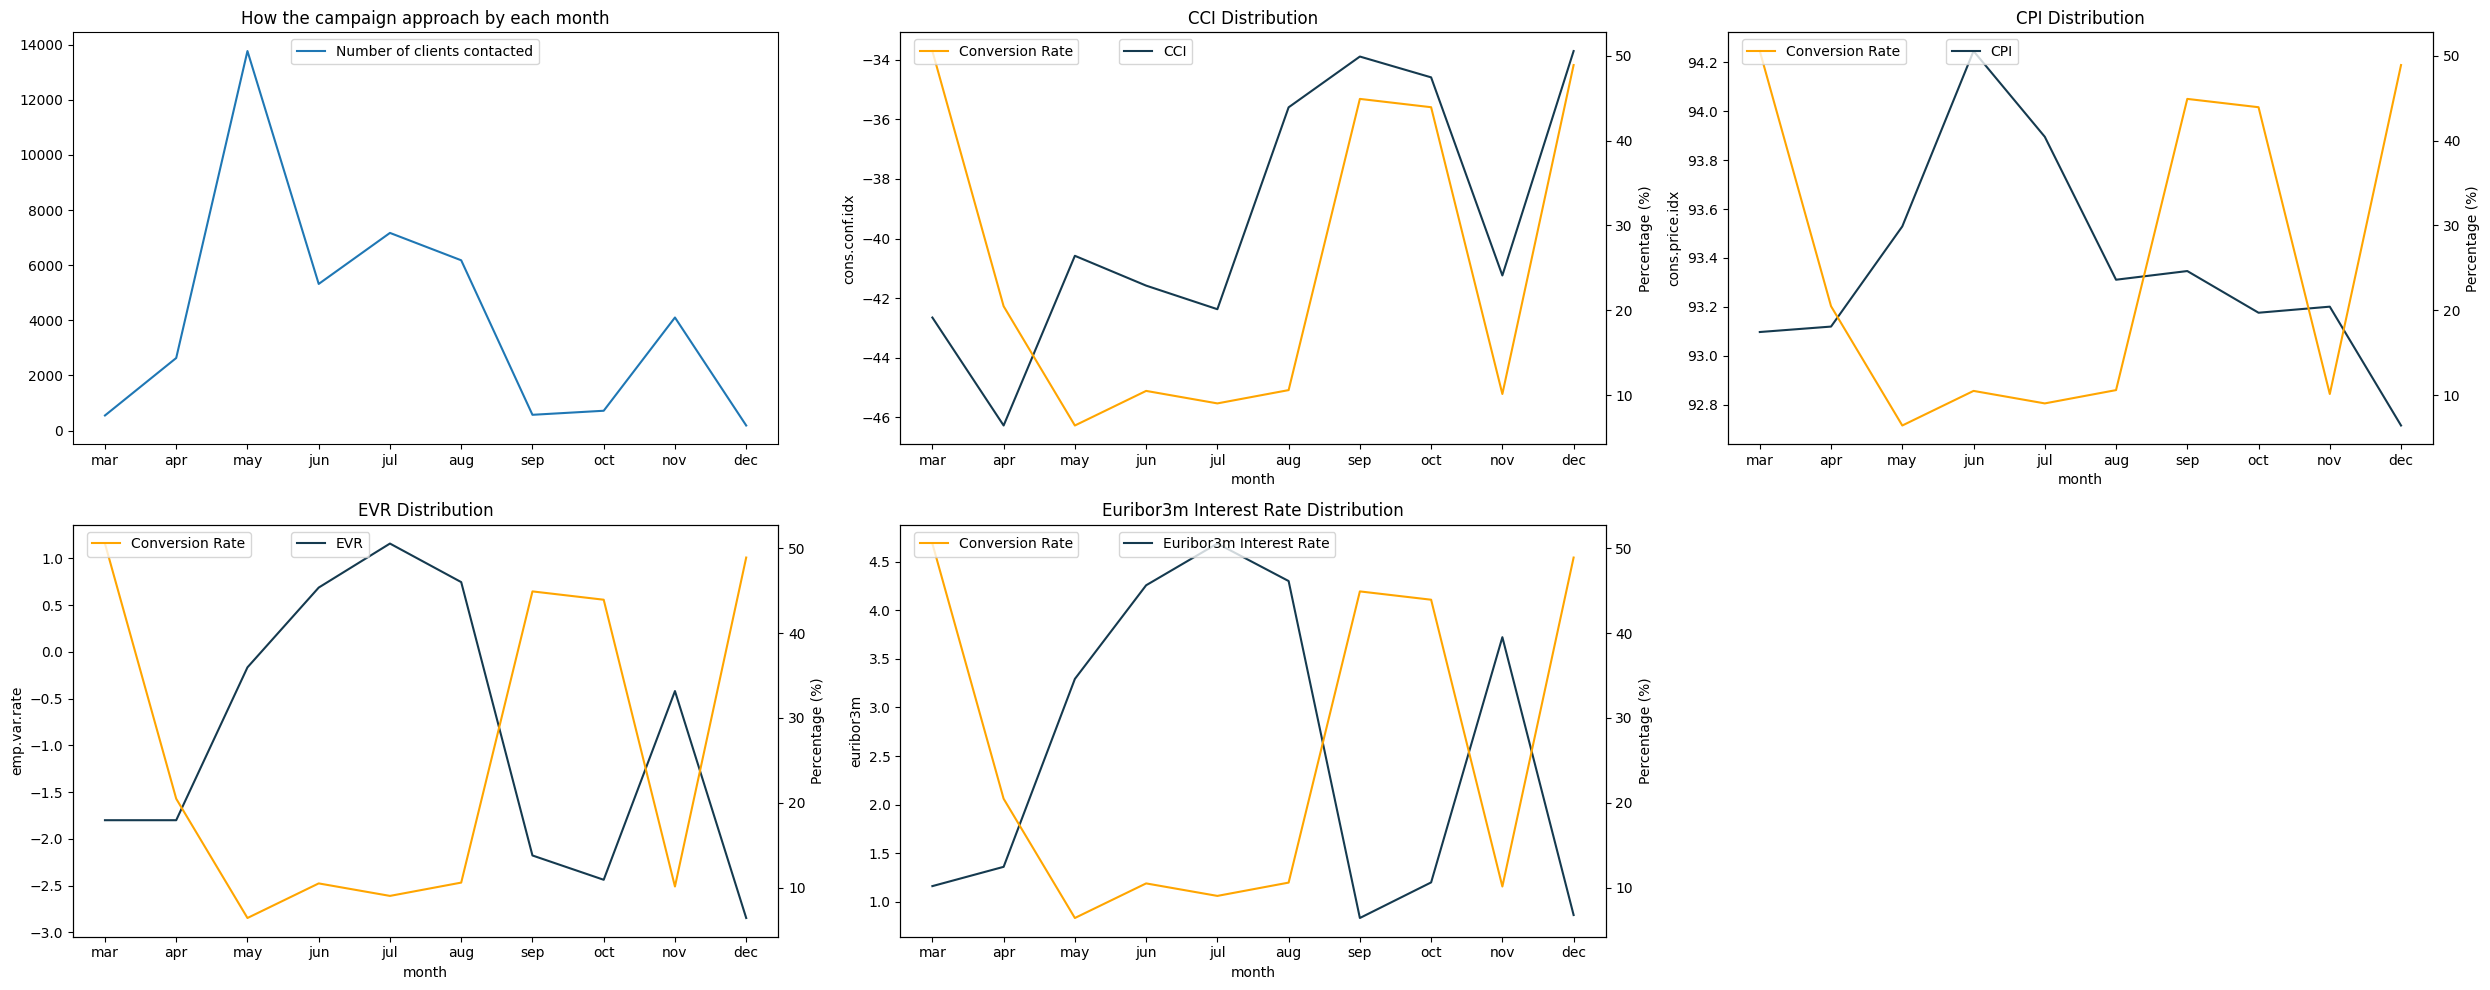

In [25]:
cate = ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m']
order = {'month':['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']}
name = {'emp.var.rate': 'EVR', 'cons.price.idx': 'CPI', 'cons.conf.idx': 'CCI', 'euribor3m': 'Euribor3m Interest Rate'}

plt.figure(figsize=(25, 10))

data_target = data[['month', 'y']].groupby(['month', 'y'], observed=False).size().reset_index(name='count')
data_target_pivot = data_target.pivot(index='month', columns='y', values='count').fillna(0)
data_target_pivot['total'] = data_target_pivot['yes'] + data_target_pivot['no']
data_target_pivot['percent_yes'] = (data_target_pivot['yes'] / data_target_pivot['total']) * 100
data_target_pivot.reset_index(inplace=True)
data_target_pivot['month'] = pd.Categorical(data_target_pivot['month'], categories=order['month'], ordered=True)
data_target_pivot = data_target_pivot.sort_values(by='month')

for i, attr in enumerate(cate, 2):
    plt.subplot(2, 3, i)

    data_index = data[[attr, 'month']].groupby(['month'], observed=False).mean()
    data_index.reset_index(inplace=True)
    data_index['month'] = pd.Categorical(data_index['month'], categories=order['month'], ordered=True)
    data_index = data_index.sort_values(by='month')

    ax1 = sns.lineplot(x='month', y=attr, data=data_index, color='#153A4F')
    ax1.legend([f'{name[attr]}'], loc='upper left', bbox_to_anchor=(0.3, 1), ncol=2)

    ax2 = ax1.twinx()
    ax2.plot(data_target_pivot['month'], data_target_pivot['percent_yes'], color='orange')
    ax2.set_ylabel('Percentage (%)')
    ax2.yaxis.grid(False)

    ax2.legend(['Conversion Rate'], loc='upper left', bbox_to_anchor=(0.01, 1), ncol=2)
    plt.title(f'{name[attr]} Distribution')
plt.subplot(2, 3, 1)
plt.plot(data_target_pivot['month'], data_target_pivot['total'])
plt.title(f'How the campaign approach by each month')
plt.legend([f'Number of clients contacted'], loc='upper left', bbox_to_anchor=(0.3, 1), ncol=2)
plt.tight_layout()


There's a strong link between macroeconomic factors and the conversion rate of our banking campaign. While these factors are beyond our control, they significantly influence customer sentiment and financial decisions.

**Key Findings**:
- **Consumer Confidence Index (CCI)**:
A higher CCI reflects consumer optimism about the economy, increasing their willingness to commit funds to term deposits. When confidence is low, customers adopt a more cautious approach, reducing conversion rates.

- **Negative Correlation with Conversion Rate**:
The conversion rate tends to decline when the following economic indicators rise:
    - Euribor 3M (Euro Interbank Offered Rate - 3 months): Higher Euribor increases borrowing costs, discouraging spending and reducing disposable income available for savings.
    - Consumer Price Index (CPI): Rising inflation erodes purchasing power, making customers more hesitant to lock their funds into term deposits.
    - Economic Volatility Rate (EVR): Increased market uncertainty makes customers more risk-averse, leading them to postpone financial commitments.

**Strategic Implications**:
- During Economic Downturns (Low CCI, High Euribor, High EVR):
    - Offer higher deposit interest rates to attract cautious customers.
    - Emphasize financial security and stability, reassuring customers that term deposits are a safe option.
    - Use targeted promotions such as limited-time incentives or bonus interest rates to encourage sign-ups.

- During Economic Stability & Growth (High CCI, Low Euribor, Low EVR):
    - Promote long-term savings plans, capitalizing on consumer optimism.
    - Highlight wealth-building benefits of term deposits as part of a financial growth strategy.
    - Leverage strong customer sentiment to introduce premium savings products with added benefits.

## E.Modeling

In [26]:
THRESHOLD = 0.6

In [27]:
#Replace unknown values to NaN
for col in data.columns:
    if data[col].dtypes == 'object':
        data.loc[data[col] == 'unknown', col] = np.nan

#Change yes, no values to number
changed_cols = ['default', 'housing', 'loan', 'y']
for col in changed_cols:
    data[col] = data[col].apply(lambda x : 1 if x == 'yes' else 0)

#Replace 999 values in pdays
data['pdays_999'] = np.where(data['pdays'] == 999, 1, 0)
data.loc[data['pdays'] == 999, 'pdays'] = -1 

#Drop unrelevant columns
data = data.drop(columns=['month', 'day_of_week', 'contact'])

#Replace values in education column
education_map = {
    'illiterate': 0, 'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3, 
    'high.school': 4, 'university.degree': 5, 'professional.course': 6
}
data['education'] = data['education'].map(education_map)

In [28]:
df_train, df_test = train_test_split(data, test_size=0.3, stratify = data['y'], random_state=42)
print('Data shape:', df_train.shape, df_test.shape)

X_train = df_train.drop(['y'], axis=1)
y_train = df_train.y

X_test = df_test.drop(['y'], axis=1)
y_test = df_test.y
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

Data shape: (28823, 19) (12353, 19)
Training data shape: (28823, 18) (28823,)
Testing data shape: (12353, 18) (12353,)


In [29]:
cat_cols = ['job', 'marital', 'poutcome']
num_cols = [
    'age', 'education', 'default', 'housing', 'loan',
    'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 
    'pdays_999', 'duration'
]

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ]
)

# pipeline = Pipeline(
#     steps=[
#         ('preprocess', preprocess),
#         ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
#         ('model', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42))
#     ]
# )

pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)),
    ('model', RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42))
])
pipeline.fit(X_train, y_train)

y_train_prob = pipeline.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob >= THRESHOLD).astype(int)
print(f'Accuracy on train: {accuracy_score(y_train, y_train_pred):.2f}')

y_test_prob = pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= THRESHOLD).astype(int)
print(f'Accuracy on test: {accuracy_score(y_test, y_test_pred):.2f}')


Accuracy on train: 0.92
Accuracy on test: 0.91


### Cross Validation

In [30]:
# # Cross validation with custom fbeta scorer
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# scores = []

# for train_idx, val_idx in cv.split(X_train, y_train):
#     X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#     y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
#     pipeline.fit(X_tr, y_tr)
#     y_prob = pipeline.predict_proba(X_val)[:, 1]
#     y_pred = (y_prob >= THRESHOLD).astype(int)
#     score = fbeta_score(y_val, y_pred, beta=1, zero_division=0)
#     scores.append(score)

# scores = np.array(scores)
# print('Mean Fbeta: {:.03f} (+/- {:.03f})'.format(np.mean(scores), np.std(scores)))

### Evaluate multiple model

In [31]:
# Evaluate multiple models with threshold optimization
models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    # 'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
thresholds = np.arange(0.3, 0.7, 0.05)

all_scores = {}
best_thresholds = {}

for name, model in models.items():
    print(f'Evaluating {name}...')
    completed_pl = Pipeline(steps=[
        ('preprocess', preprocess),
        ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)),
        ('model', model)
    ])
    
    threshold_scores = {t: [] for t in thresholds}
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        completed_pl.fit(X_tr, y_tr)
        y_prob = completed_pl.predict_proba(X_val)[:, 1]
        
        for t in thresholds:
            y_pred = (y_prob >= t).astype(int)
            score = fbeta_score(y_val, y_pred, beta=1, zero_division=0)
            threshold_scores[t].append(score)
    
    mean_scores = {t: np.mean(s) for t, s in threshold_scores.items()}
    best_t = max(mean_scores, key=mean_scores.get)
    best_thresholds[name] = best_t
    all_scores[name] = threshold_scores[best_t]
    
    print(f'Best threshold: {best_t:.2f}, Mean Fbeta: {mean_scores[best_t]:.3f}')

print('\n===== Summary =====')
for name in models.keys():
    scores = all_scores[name]
    print(f'{name}: Threshold = {best_thresholds[name]:.2f}, Fbeta = {np.mean(scores):.3f}')

Evaluating Logistic...
Best threshold: 0.55, Mean Fbeta: 0.603
Evaluating MLP...
Best threshold: 0.30, Mean Fbeta: 0.561
Evaluating RandomForest...
Best threshold: 0.40, Mean Fbeta: 0.634
Evaluating XGBoost...
Best threshold: 0.35, Mean Fbeta: 0.633
Evaluating LightGBM...
Best threshold: 0.35, Mean Fbeta: 0.645

===== Summary =====
Logistic: Threshold = 0.55, Fbeta = 0.603
MLP: Threshold = 0.30, Fbeta = 0.561
RandomForest: Threshold = 0.40, Fbeta = 0.634
XGBoost: Threshold = 0.35, Fbeta = 0.633
LightGBM: Threshold = 0.35, Fbeta = 0.645


In [32]:
# CatBoost evaluation
thresholds = np.arange(0.2, 0.7, 0.05)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

threshold_scores = {t: [] for t in thresholds}

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr = X_train.iloc[train_idx].copy()
    X_val = X_train.iloc[val_idx].copy()
    y_tr = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]
    
    for col in num_cols:
        if col in X_tr.columns:
            median_val = X_tr[col].median()
            X_tr[col] = X_tr[col].fillna(median_val)
            X_val[col] = X_val[col].fillna(median_val)
    
    for col in cat_cols:
        if col in X_tr.columns:
            mode_val = X_tr[col].mode()[0] if not X_tr[col].mode().empty else 'unknown'
            X_tr[col] = X_tr[col].fillna(mode_val)
            X_val[col] = X_val[col].fillna(mode_val)
    
    cat_features_idx = [X_tr.columns.get_loc(c) for c in cat_cols if c in X_tr.columns]
    
    model = CatBoostClassifier(
        iterations=500, depth=6, learning_rate=0.05, loss_function='Logloss',
        class_weights=[1, (y_tr == 0).sum() / (y_tr == 1).sum()], eval_metric='F1',
        cat_features=cat_features_idx, random_seed=42, verbose=False
    )
    
    model.fit(X_tr, y_tr)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        score = fbeta_score(y_val, y_pred, beta=1, zero_division=0)
        threshold_scores[t].append(score)

mean_scores = {t: np.mean(s) for t, s in threshold_scores.items()}
best_t = max(mean_scores, key=mean_scores.get)

print(f'CatBoost Results:')
print(f'Best threshold: {best_t:.2f}')
print(f'Mean Fbeta: {mean_scores[best_t]:.3f}')

all_scores['CatBoost'] = threshold_scores[best_t]
best_thresholds['CatBoost'] = best_t

CatBoost Results:
Best threshold: 0.65
Mean Fbeta: 0.637


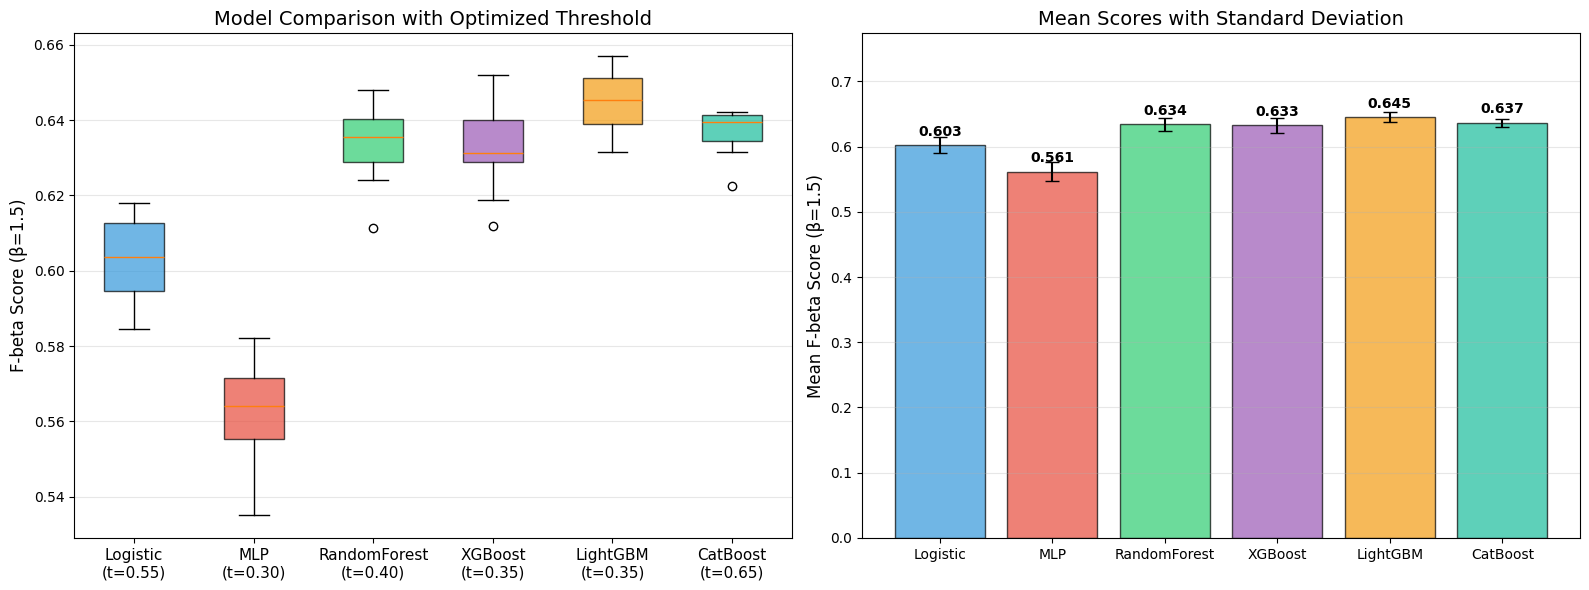


Best Model: LightGBM with Threshold=0.35, Fbeta=0.645


In [33]:
model_names = list(all_scores.keys())
scores_data = [all_scores[name] for name in model_names]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
bp = ax1.boxplot(scores_data, patch_artist=True)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_xticklabels([f'{name}\n(t={best_thresholds[name]:.2f})' for name in model_names], rotation=0, fontsize=11)
ax1.set_ylabel('F-beta Score (β=1.5)', fontsize=12)
ax1.set_title('Model Comparison with Optimized Threshold', fontsize=14)
ax1.grid(axis='y', alpha=0.3)

# Mean Scores with Standard Deviation
ax2 = axes[1]
means = [np.mean(all_scores[name]) for name in model_names]
stds = [np.std(all_scores[name]) for name in model_names]
bars = ax2.bar(model_names, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Mean F-beta Score (β=1.5)', fontsize=12)
ax2.set_title('Mean Scores with Standard Deviation', fontsize=14)
ax2.set_ylim(0, max(means) * 1.2)
ax2.grid(axis='y', alpha=0.3)

for bar, mean, thresh in zip(bars, means, [best_thresholds[n] for n in model_names]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Best model
best_model = max(model_names, key=lambda x: np.mean(all_scores[x]))
print(f'\nBest Model: {best_model} with Threshold={best_thresholds[best_model]:.2f}, Fbeta={np.mean(all_scores[best_model]):.3f}')

### Hyperparameters + Threshold tuning

In [34]:
# LightGBM
thresholds_tune = np.arange(0.3, 0.7, 0.05)

def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    threshold = trial.suggest_float('threshold', 0.3, 0.65)
    
    model = LGBMClassifier(**params, subsample_freq=1, random_state=42, verbose=-1)
    
    pl = Pipeline(steps=[
        ('preprocess', preprocess),
        ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)),
        ('model', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        pl.fit(X_tr, y_tr)
        y_prob = pl.predict_proba(X_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        score = fbeta_score(y_val, y_pred, beta=1, zero_division=0)
        scores.append(score)
    
    return np.mean(scores)

print('=' * 50)
print('LightGBM Hyperparameter + Threshold Tuning')
print('=' * 50)

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=20, show_progress_bar=True)

print(f'\nBest LightGBM trial:')
print(f'Fbeta: {lgbm_study.best_value:.4f}')
print(f'Best threshold: {lgbm_study.best_params['threshold']:.3f}')
print(f'Best params: {lgbm_study.best_params}')

[I 2026-01-13 13:16:59,697] A new study created in memory with name: no-name-ac51f19a-2b96-4796-a36b-2dad79abff80


LightGBM Hyperparameter + Threshold Tuning


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-13 13:17:05,295] Trial 0 finished with value: 0.5552857090149714 and parameters: {'n_estimators': 300, 'max_depth': 8, 'num_leaves': 54, 'learning_rate': 0.025024612950393838, 'min_child_samples': 81, 'reg_alpha': 0.8968697433232357, 'reg_lambda': 0.9275916190192546, 'subsample': 0.9523559710177079, 'colsample_bytree': 0.8170535905983776, 'threshold': 0.621742228088173}. Best is trial 0 with value: 0.5552857090149714.
[I 2026-01-13 13:17:07,023] Trial 1 finished with value: 0.6326127844519792 and parameters: {'n_estimators': 150, 'max_depth': 3, 'num_leaves': 27, 'learning_rate': 0.12383207808702879, 'min_child_samples': 62, 'reg_alpha': 0.06403110896879827, 'reg_lambda': 0.8361381038152792, 'subsample': 0.8919615433270163, 'colsample_bytree': 0.9477728637738303, 'threshold': 0.3420653569801299}. Best is trial 1 with value: 0.6326127844519792.
[I 2026-01-13 13:17:11,619] Trial 2 finished with value: 0.5122098895203183 and parameters: {'n_estimators': 400, 'max_depth': 5, 'nu

In [35]:
# CatBoost
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 600, step=50),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }
    threshold = trial.suggest_float('threshold', 0.3, 0.65)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[val_idx].copy()
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]
        
        for col in num_cols:
            if col in X_tr.columns:
                median_val = X_tr[col].median()
                X_tr[col] = X_tr[col].fillna(median_val)
                X_val[col] = X_val[col].fillna(median_val)
        
        for col in cat_cols:
            if col in X_tr.columns:
                mode_val = X_tr[col].mode()[0] if not X_tr[col].mode().empty else 'unknown'
                X_tr[col] = X_tr[col].fillna(mode_val)
                X_val[col] = X_val[col].fillna(mode_val)
        
        cat_features_idx = [X_tr.columns.get_loc(c) for c in cat_cols if c in X_tr.columns]
        
        model = CatBoostClassifier(
            **params, loss_function='Logloss',
            class_weights=[1, (y_tr == 0).sum() / (y_tr == 1).sum()],
            cat_features=cat_features_idx, random_seed=42, verbose=False
        )
        
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        score = fbeta_score(y_val, y_pred, beta=1, zero_division=0)
        scores.append(score)
    
    return np.mean(scores)

print('\n' + '=' * 50)
print('CatBoost Hyperparameter + Threshold Tuning')
print('=' * 50)

catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(catboost_objective, n_trials=20, show_progress_bar=True)

print(f'\nBest CatBoost trial:')
print(f'Fbeta: {catboost_study.best_value:.4f}')
print(f'Best threshold: {catboost_study.best_params['threshold']:.3f}')
print(f'Best params: {catboost_study.best_params}')

[I 2026-01-13 13:18:12,203] A new study created in memory with name: no-name-050662a1-4514-4ca0-b8df-545ea8fe3f24



CatBoost Hyperparameter + Threshold Tuning


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-13 13:19:01,391] Trial 0 finished with value: 0.5864243655948269 and parameters: {'iterations': 200, 'depth': 7, 'learning_rate': 0.07408692311605233, 'l2_leaf_reg': 4.510232727486791, 'border_count': 115, 'bagging_temperature': 0.8106213106269844, 'threshold': 0.41233901939754025}. Best is trial 0 with value: 0.5864243655948269.
[I 2026-01-13 13:19:56,303] Trial 1 finished with value: 0.6320756585617053 and parameters: {'iterations': 300, 'depth': 5, 'learning_rate': 0.12156215497876313, 'l2_leaf_reg': 5.709451739706786, 'border_count': 48, 'bagging_temperature': 0.6094995392080058, 'threshold': 0.6377351846647465}. Best is trial 1 with value: 0.6320756585617053.
[I 2026-01-13 13:20:45,320] Trial 2 finished with value: 0.620294765176405 and parameters: {'iterations': 250, 'depth': 5, 'learning_rate': 0.03475399618712242, 'l2_leaf_reg': 9.733581785046454, 'border_count': 105, 'bagging_temperature': 0.12074973622179741, 'threshold': 0.6176709522714474}. Best is trial 1 with v

## F. Final model

### Single model

In [36]:
# Compare Best Models on Test Set
print('Final Evaluation on Test Set')

# LightGBM
lgbm_params = {k: v for k, v in lgbm_study.best_params.items() if k != 'threshold'}
lgbm_threshold = lgbm_study.best_params['threshold']

lgbm_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)),
    ('model', LGBMClassifier(**lgbm_params, subsample_freq=1, random_state=42, verbose=-1))
])
lgbm_pipeline.fit(X_train, y_train)

y_test_prob_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]
y_test_pred_lgbm = (y_test_prob_lgbm >= lgbm_threshold).astype(int)

print('\n LightGBM Results:')
print(f'Threshold: {lgbm_threshold:.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_lgbm):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_lgbm, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_lgbm):.4f}')
print(f'F1-score: {f1_score(y_test, y_test_pred_lgbm):.4f}')
print(f'Fbeta: {fbeta_score(y_test, y_test_pred_lgbm, beta=1, zero_division=0):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_prob_lgbm):.4f}')

# CatBoost
catboost_params = {k: v for k, v in catboost_study.best_params.items() if k != 'threshold'}
catboost_threshold = catboost_study.best_params['threshold']

X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

for col in num_cols:
    if col in X_train_cb.columns:
        median_val = X_train_cb[col].median()
        X_train_cb[col] = X_train_cb[col].fillna(median_val)
        X_test_cb[col] = X_test_cb[col].fillna(median_val)

for col in cat_cols:
    if col in X_train_cb.columns:
        mode_val = X_train_cb[col].mode()[0] if not X_train_cb[col].mode().empty else 'unknown'
        X_train_cb[col] = X_train_cb[col].fillna(mode_val)
        X_test_cb[col] = X_test_cb[col].fillna(mode_val)

cat_features_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols if c in X_train_cb.columns]

catboost_model = CatBoostClassifier(
    **catboost_params, loss_function='Logloss',
    class_weights=[1, (y_train == 0).sum() / (y_train == 1).sum()], 
    cat_features=cat_features_idx,  random_seed=42, verbose=False
)
catboost_model.fit(X_train_cb, y_train)

y_test_prob_cb = catboost_model.predict_proba(X_test_cb)[:, 1]
y_test_pred_cb = (y_test_prob_cb >= catboost_threshold).astype(int)

print('\n CatBoost Results:')
print(f'Threshold: {catboost_threshold:.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_cb):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_cb, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_cb):.4f}')
print(f'F1-score: {f1_score(y_test, y_test_pred_cb):.4f}')
print(f'Fbeta: {fbeta_score(y_test, y_test_pred_cb, beta=1, zero_division=0):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_prob_cb):.4f}')

# Best Model
lgbm_fbeta = fbeta_score(y_test, y_test_pred_lgbm, beta=1, zero_division=0)
cb_fbeta = fbeta_score(y_test, y_test_pred_cb, beta=1, zero_division=0)

print('\n' + '=' * 60)
if lgbm_fbeta > cb_fbeta:
    print(f'Best Model: LightGBM (Fbeta={lgbm_fbeta:.4f})')
    best_final_model = 'LightGBM'
    best_pred = y_test_pred_lgbm
else:
    print(f'Best Model: CatBoost (Fbeta={cb_fbeta:.4f})')
    best_final_model = 'CatBoost'
    best_pred = y_test_pred_cb

print('\nConfusion Matrix (Best Model):')
print(confusion_matrix(y_test, best_pred))

print('\nClassification Report (Best Model):')
print(classification_report(y_test, best_pred, zero_division=0))

Final Evaluation on Test Set

 LightGBM Results:
Threshold: 0.386
Accuracy: 0.9039
Precision: 0.5529
Recall: 0.7694
F1-score: 0.6434
Fbeta: 0.6434
ROC-AUC: 0.9468

 CatBoost Results:
Threshold: 0.649
Accuracy: 0.8953
Precision: 0.5220
Recall: 0.8448
F1-score: 0.6453
Fbeta: 0.6453
ROC-AUC: 0.9477

Best Model: CatBoost (Fbeta=0.6453)

Confusion Matrix (Best Model):
[[9884 1077]
 [ 216 1176]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     10961
           1       0.52      0.84      0.65      1392

    accuracy                           0.90     12353
   macro avg       0.75      0.87      0.79     12353
weighted avg       0.93      0.90      0.91     12353



In [37]:
joblib.dump(
    {
        'model': lgbm_pipeline,
        'threshold': lgbm_threshold
    },
    'lgbm_pipeline_fbeta15.pkl'
)
catboost_model.save_model(
    'catboost_fbeta15.cbm',
    format='cbm'
)

with open('catboost_threshold.json', 'w') as f:
    json.dump({'threshold': catboost_threshold}, f)

### Stacking model

In [38]:
# Stacking Ensemble: LightGBM + CatBoost
# Method 1: Soft Voting
print('Method 1: Probability Averaging')
y_test_prob_avg = (y_test_prob_lgbm + y_test_prob_cb) / 2

best_avg_score = 0
best_avg_threshold = 0.5

for thresh in np.arange(0.3, 0.7, 0.05):
    y_pred_avg = (y_test_prob_avg >= thresh).astype(int)
    score = fbeta_score(y_test, y_pred_avg, beta=1, zero_division=0)
    if score > best_avg_score:
        best_avg_score = score
        best_avg_threshold = thresh

y_test_pred_avg = (y_test_prob_avg >= best_avg_threshold).astype(int)

print(f'\nBest Threshold: {best_avg_threshold:.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_avg):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_avg, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_avg):.4f}')
print(f'F1-score: {f1_score(y_test, y_test_pred_avg):.4f}')
print(f'Fbeta: {fbeta_score(y_test, y_test_pred_avg, beta=1, zero_division=0):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_prob_avg):.4f}')

print('\nConfusion Matrix (Probability Averaging):')
print(confusion_matrix(y_test, y_test_pred_avg))
print('\nClassification Report (Probability Averaging):')
print(classification_report(y_test, y_test_pred_avg, zero_division=0))

Method 1: Probability Averaging

Best Threshold: 0.550
Accuracy: 0.9046
Precision: 0.5538
Recall: 0.7917
F1-score: 0.6517
Fbeta: 0.6517
ROC-AUC: 0.9485

Confusion Matrix (Probability Averaging):
[[10073   888]
 [  290  1102]]

Classification Report (Probability Averaging):
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10961
           1       0.55      0.79      0.65      1392

    accuracy                           0.90     12353
   macro avg       0.76      0.86      0.80     12353
weighted avg       0.92      0.90      0.91     12353



In [39]:
# Method 2: Weighted Averaging
print('Method 2: Weighted Probability Averaging')

best_weighted_score = 0
best_weights = (0.5, 0.5)
best_weighted_threshold = 0.5

for w1 in np.arange(0.1, 1.0, 0.1):
    w2 = 1 - w1
    y_prob_weighted = w1 * y_test_prob_lgbm + w2 * y_test_prob_cb
    
    for thresh in np.arange(0.3, 0.7, 0.05):
        y_pred_weighted = (y_prob_weighted >= thresh).astype(int)
        score = fbeta_score(y_test, y_pred_weighted, beta=1, zero_division=0)
        if score > best_weighted_score:
            best_weighted_score = score
            best_weights = (w1, w2)
            best_weighted_threshold = thresh

y_test_prob_weighted = best_weights[0] * y_test_prob_lgbm + best_weights[1] * y_test_prob_cb
y_test_pred_weighted = (y_test_prob_weighted >= best_weighted_threshold).astype(int)

print(f'\nBest Weights: LightGBM={best_weights[0]:.2f}, CatBoost={best_weights[1]:.2f}')
print(f'Best Threshold: {best_weighted_threshold:.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_weighted):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_weighted, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_weighted):.4f}')
print(f'F1-score: {f1_score(y_test, y_test_pred_weighted):.4f}')
print(f'Fbeta: {fbeta_score(y_test, y_test_pred_weighted, beta=1, zero_division=0):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_prob_weighted):.4f}')

print('\n Confusion Matrix (Weighted Averaging):')
print(confusion_matrix(y_test, y_test_pred_weighted))
print('\n Classification Report (Weighted Averaging):')
print(classification_report(y_test, y_test_pred_weighted, zero_division=0))

Method 2: Weighted Probability Averaging

Best Weights: LightGBM=0.30, CatBoost=0.70
Best Threshold: 0.600
Accuracy: 0.9033
Precision: 0.5478
Recall: 0.8147
F1-score: 0.6551
Fbeta: 0.6551
ROC-AUC: 0.9485

 Confusion Matrix (Weighted Averaging):
[[10025   936]
 [  258  1134]]

 Classification Report (Weighted Averaging):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     10961
           1       0.55      0.81      0.66      1392

    accuracy                           0.90     12353
   macro avg       0.76      0.86      0.80     12353
weighted avg       0.93      0.90      0.91     12353



In [40]:
# Method 3: Stacking with Logistic Regression Meta-learner
print('Method 3: Stacking with Logistic Regression Meta-learner')

X_stack_train = np.column_stack([
    lgbm_pipeline.predict_proba(X_train)[:, 1],
    catboost_model.predict_proba(X_train_cb)[:, 1]
])

X_stack_test = np.column_stack([
    y_test_prob_lgbm,
    y_test_prob_cb
])

# Train meta-learner
meta_learner = LogisticRegression(random_state=42, max_iter=1000)
meta_learner.fit(X_stack_train, y_train)

y_test_prob_stack = meta_learner.predict_proba(X_stack_test)[:, 1]

best_stack_score = 0
best_stack_threshold = 0.5

for thresh in np.arange(0.3, 0.7, 0.05):
    y_pred_stack = (y_test_prob_stack >= thresh).astype(int)
    score = fbeta_score(y_test, y_pred_stack, beta=1, zero_division=0)
    if score > best_stack_score:
        best_stack_score = score
        best_stack_threshold = thresh

y_test_pred_stack = (y_test_prob_stack >= best_stack_threshold).astype(int)

print(f'\nMeta-learner coefficients:')
print(f'- LightGBM weight: {meta_learner.coef_[0][0]:.4f}')
print(f'- CatBoost weight: {meta_learner.coef_[0][1]:.4f}')
print(f'- Intercept: {meta_learner.intercept_[0]:.4f}')
print(f'Best Threshold: {best_stack_threshold:.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_stack):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_stack, zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_stack):.4f}')
print(f'F1-score: {f1_score(y_test, y_test_pred_stack):.4f}')
print(f'Fbeta: {fbeta_score(y_test, y_test_pred_stack, beta=1, zero_division=0):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_prob_stack):.4f}')

print('\nConfusion Matrix (Stacking with LR):')
print(confusion_matrix(y_test, y_test_pred_stack))
print('\nClassification Report (Stacking with LR):')
print(classification_report(y_test, y_test_pred_stack, zero_division=0))

Method 3: Stacking with Logistic Regression Meta-learner

Meta-learner coefficients:
- LightGBM weight: -1.0205
- CatBoost weight: 9.0026
- Intercept: -6.8446
Best Threshold: 0.350
Accuracy: 0.9067
Precision: 0.5613
Recall: 0.7866
F1-score: 0.6551
Fbeta: 0.6551
ROC-AUC: 0.9468

Confusion Matrix (Stacking with LR):
[[10105   856]
 [  297  1095]]

Classification Report (Stacking with LR):
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     10961
           1       0.56      0.79      0.66      1392

    accuracy                           0.91     12353
   macro avg       0.77      0.85      0.80     12353
weighted avg       0.93      0.91      0.91     12353



In [41]:
print('FINAL STACKING RESULTS SUMMARY')

avg_fbeta = fbeta_score(y_test, y_test_pred_avg, beta=1, zero_division=0)
weighted_fbeta = fbeta_score(y_test, y_test_pred_weighted, beta=1, zero_division=0)
stack_fbeta = fbeta_score(y_test, y_test_pred_stack, beta=1, zero_division=0)

results_df = pd.DataFrame({
    'Model': ['LightGBM (Base)', 'CatBoost (Base)', 'Avg Ensemble', 'Weighted Ensemble', 'Stacking (LR)'],
    'Threshold': [lgbm_threshold, catboost_threshold, best_avg_threshold, best_weighted_threshold, best_stack_threshold],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_lgbm),
        accuracy_score(y_test, y_test_pred_cb),
        accuracy_score(y_test, y_test_pred_avg),
        accuracy_score(y_test, y_test_pred_weighted),
        accuracy_score(y_test, y_test_pred_stack)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_lgbm, zero_division=0),
        precision_score(y_test, y_test_pred_cb, zero_division=0),
        precision_score(y_test, y_test_pred_avg, zero_division=0),
        precision_score(y_test, y_test_pred_weighted, zero_division=0),
        precision_score(y_test, y_test_pred_stack, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_lgbm),
        recall_score(y_test, y_test_pred_cb),
        recall_score(y_test, y_test_pred_avg),
        recall_score(y_test, y_test_pred_weighted),
        recall_score(y_test, y_test_pred_stack)
    ],
    'F1-score': [
        f1_score(y_test, y_test_pred_lgbm),
        f1_score(y_test, y_test_pred_cb),
        f1_score(y_test, y_test_pred_avg),
        f1_score(y_test, y_test_pred_weighted),
        f1_score(y_test, y_test_pred_stack)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_test_prob_lgbm),
        roc_auc_score(y_test, y_test_prob_cb),
        roc_auc_score(y_test, y_test_prob_avg),
        roc_auc_score(y_test, y_test_prob_weighted),
        roc_auc_score(y_test, y_test_prob_stack)
    ]
})

results_df = results_df.sort_values('F1-score', ascending=False)
print('\nAll Models Comparison:')
print(results_df.to_string(index=False))

# Best overall model
all_models_fbeta = {
    'LightGBM': lgbm_fbeta,
    'CatBoost': cb_fbeta,
    'Avg Ensemble': avg_fbeta,
    'Weighted Ensemble': weighted_fbeta,
    'Stacking (LR)': stack_fbeta
}

best_model_name = max(all_models_fbeta, key=all_models_fbeta.get)
best_model_score = all_models_fbeta[best_model_name]

print(f'\nBEST OVERALL MODEL: {best_model_name}')
print(f'F1-score (Fbeta): {best_model_score:.4f}')

improvement_over_lgbm = ((best_model_score - lgbm_fbeta) / lgbm_fbeta) * 100
improvement_over_cb = ((best_model_score - cb_fbeta) / cb_fbeta) * 100

print(f'\n Performance Improvement:')
print(f'vs LightGBM: {improvement_over_lgbm:+.2f}%')
print(f'vs CatBoost: {improvement_over_cb:+.2f}%')

FINAL STACKING RESULTS SUMMARY

All Models Comparison:
            Model  Threshold  Accuracy  Precision   Recall  F1-score  ROC-AUC
Weighted Ensemble   0.600000  0.903343   0.547826 0.814655  0.655113 0.948485
    Stacking (LR)   0.350000  0.906662   0.561251 0.786638  0.655100 0.946791
     Avg Ensemble   0.550000  0.904639   0.553769 0.791667  0.651685 0.948498
  CatBoost (Base)   0.649346  0.895329   0.521971 0.844828  0.645267 0.947682
  LightGBM (Base)   0.386416  0.903910   0.552917 0.769397  0.643436 0.946758

BEST OVERALL MODEL: Weighted Ensemble
F1-score (Fbeta): 0.6551

 Performance Improvement:
vs LightGBM: +1.81%
vs CatBoost: +1.53%
